In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import warnings
import itertools
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import NullFormatter
import matplotlib.image as mpimg
import seaborn as sns
import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype
import pandas_profiling
import numpy as np
import requests
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
from sklearn.feature_selection import SelectKBest
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

%matplotlib inline
#%matplotlib notebook

from IPython.display import display
import re

C:\Users\Lili\AppData\Local\Temp\ipykernel_12948\2523595125.py:11: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling



# I. Datos de Training

## Carguemos los datos

In [3]:
df= pd.read_csv("Training_values.csv")
df_target = pd.read_csv("Training_labels.csv")

## Tabla Training_values - ¿Qué tenemos?

In [4]:
# Check del tamaño del marco de los datos
df.shape

(59400, 40)

In [5]:
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [6]:
df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


## Tabla Training_labels - ¿Qué tenemos?

In [7]:
# Check del tamaño del marco de los datos
df_target.shape

(59400, 2)

In [8]:
df_target.dtypes

id               int64
status_group    object
dtype: object

In [9]:
df_target.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


### Verificamos la coincidencia de los ids para saber si podemos fusionar los datos sin problemas

In [10]:
print('Coincidencia ids train/test:\n', df['id'].isin(df_target['id']).value_counts())

Coincidencia ids train/test:
 True    59400
Name: id, dtype: int64


Como tienen la misma cantidad de filas y coinciden en el id las fusionaremos por el id.

### Fusionémos las tablas con left, siendo nuestra tabla principal df

In [11]:
df_train = df.merge(df_target, how='left', on='id')

## Nuevo Data Frame: df_train - ¿Qué tenemos?

In [12]:
df_train.shape

(59400, 41)

In [13]:
df_train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [14]:
df_train.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


## Análisis exploratorio

**Hacemos un analisis profile rápido para obtener un analisis de los datos**

**Ya que al abrir el notebook el profile no se carga, dejo aqui otro código para que se pueda ver el analisis exploratorio**

In [15]:
category_cols= df_train.select_dtypes(include=['object','category']).columns
numeric_cols = df_train.select_dtypes(exclude=['object','category']).columns

In [16]:
df_train[category_cols].describe()

,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
count,59400,55765,55745,59400,59400,59029,59400,59400,59400,56066,...,59400,59400,59400,59400,59400,59400,59400,59400,59400,59400
unique,356,1897,2145,37400,9,19287,21,125,2092,2,...,8,6,5,5,10,7,3,7,6,3
top,2011-03-15,Government Of Tanzania,DWE,none,Lake Victoria,Madukani,Iringa,Njombe,Igosi,True,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
freq,572,9084,17402,3563,10248,508,5294,2503,307,51011,...,50818,50818,33186,33186,17021,17021,45794,28522,34625,32259


In [17]:
df_train[numeric_cols].describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


### Variables numericas

Graficamos solo las variables numericas, haremos el gráfico de las variables categoricas más adelante, puesto que existen variables categoricas con muchismos valores [vease: df_train[category_cols].describe()] y no sería muy visual.

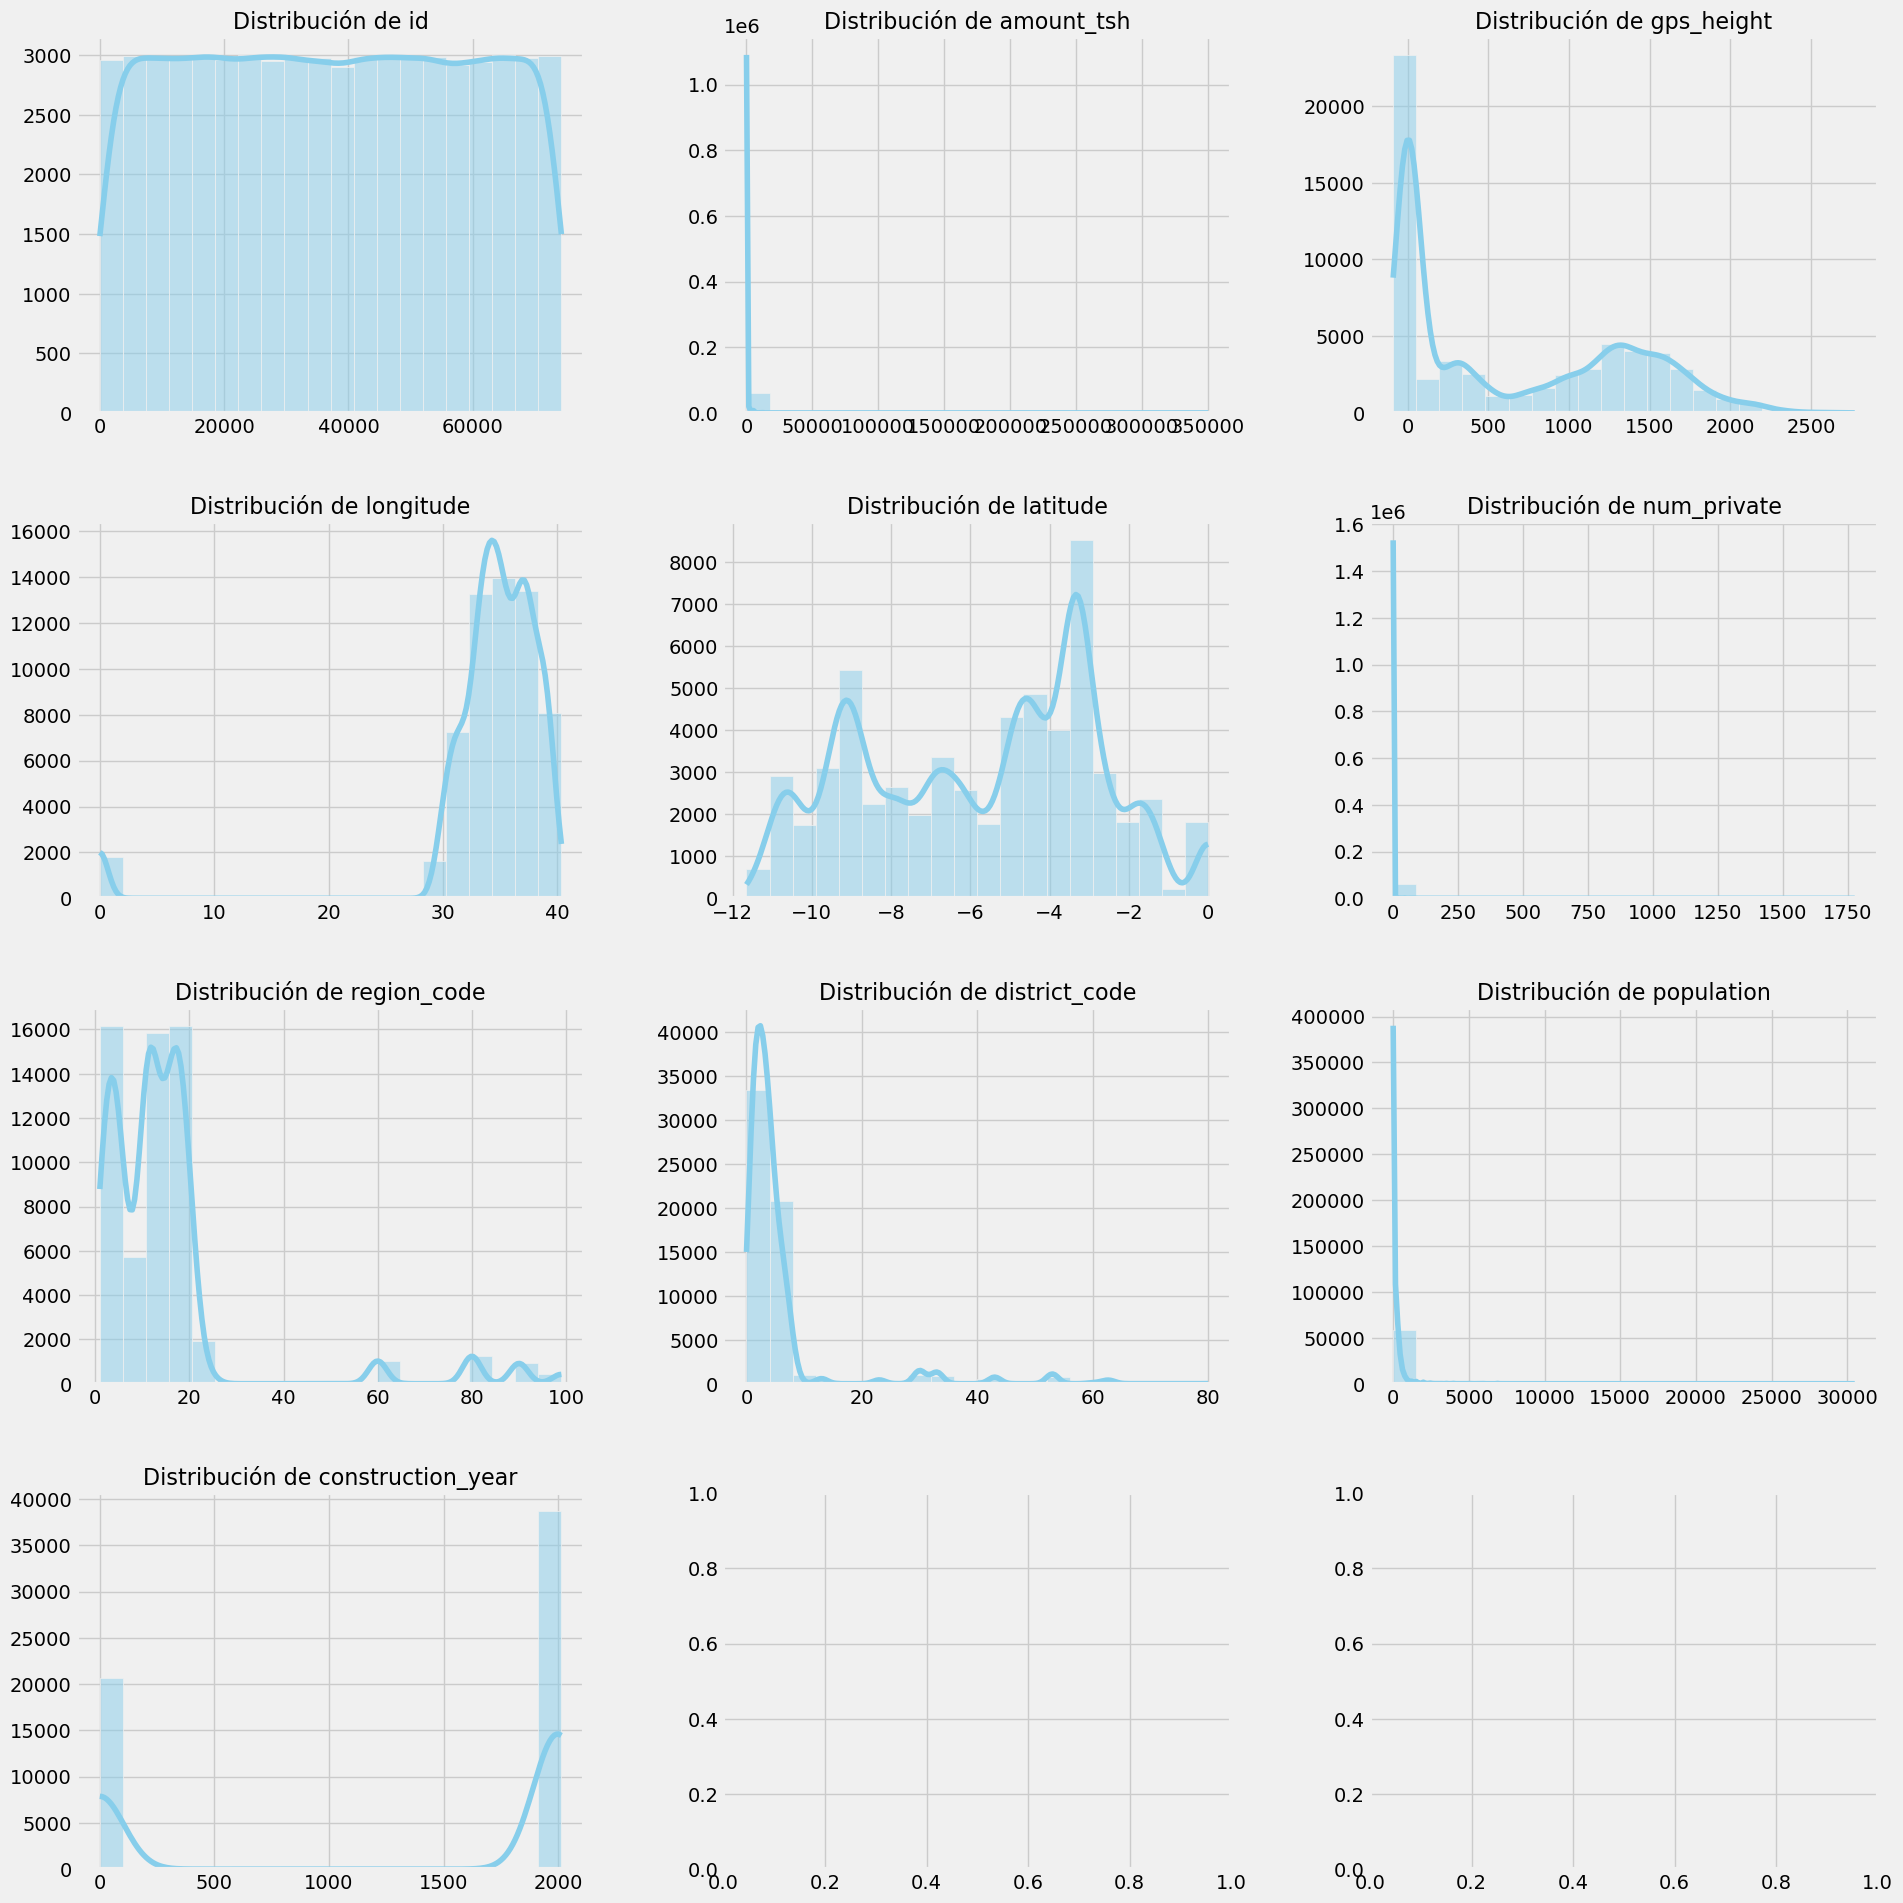

In [18]:
# Definir el tamaño del gráfico y los subgráficos
fig, axs = plt.subplots(ncols=3, nrows=4, figsize=(20, 20))
axs = axs.flatten()

# Iterar sobre las columnas del dataframe
index = 0
for k, v in df_train[numeric_cols].items():
    sns.histplot(v, bins=20, ax=axs[index], kde=True, color='skyblue')
    axs[index].set_title(f'Distribución de {k}', fontsize=16)
    axs[index].set_xlabel('')  # Eliminar etiqueta del eje x para mayor claridad
    axs[index].set_ylabel('')  # Eliminar etiqueta del eje y para mayor claridad
    index += 1

# Ajustar el espacio entre los subgráficos
plt.tight_layout(pad=3.0)

# Mostrar el gráfico
plt.show()


## Creamos una matriz de correlación para la variable respuesta (status_group)

**Primero vamos a transformar a tipo numerico nuestra variable respuesta status_group**

In [19]:
df_correlation = pd.read_csv("Training_labels.csv")

In [20]:
df_correlation['status_group'].unique()

array(['functional', 'non functional', 'functional needs repair'],
      dtype=object)

In [21]:
df_correlation.status_group.replace(('functional','functional needs repair','non functional'),(2,1,0),inplace=True)

In [22]:
df_correlation.head()

,id,status_group
0,69572,2
1,8776,2
2,34310,2
3,67743,0
4,19728,2


In [23]:
df_correlation.dtypes

id              int64
status_group    int64
dtype: object

**df**: es el data frame que contiene el resto de los atributos.

**df_correlation**: es el data frame que contiene solamente id y staus_group, siendo este ultimo de tipo numerico.

In [24]:
df_correlation1 = df.merge(df_correlation, how='left', on='id')

### Matriz de correlación para la variable respuesta (con datos numéricos)

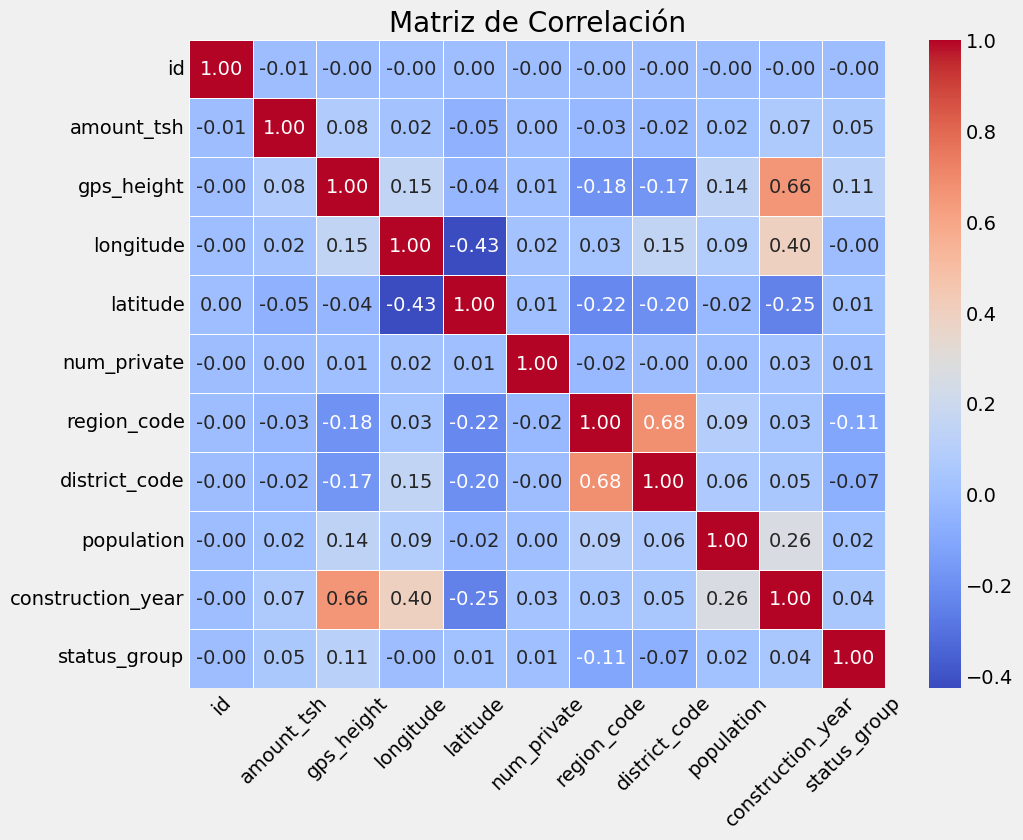

In [25]:
# Calcula la matriz de correlación
correlation_matrix = df_correlation1.corr()

# Configura el tamaño de la figura
plt.figure(figsize=(10, 8))

# Crea un mapa de calor para visualizar la matriz de correlación
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Ajusta la orientación de los ejes
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Añade un título
plt.title('Matriz de Correlación')

# Muestra el mapa de calor
plt.show()

# Preprocesado

# Transformación de variables

Primero veamos si el tipo de variables es el correcto para cada atributo

In [26]:
df_train.dtypes

id                         int64
amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_ty

## Modificación de variable: 'date_recorded' a 'days_since_recorded'

En la previsualización anterior podemos ver, que *date_recorded* no esta en un formato correcto, por ello procederemos a cambiarlo. Tiene que tener un formato de fecha

In [27]:
# Convertir la columna a datetime
df_train['date_recorded'] = pd.to_datetime(df_train['date_recorded'])

In [28]:
df_train.dtypes

id                                int64
amount_tsh                      float64
date_recorded            datetime64[ns]
funder                           object
gps_height                        int64
installer                        object
longitude                       float64
latitude                        float64
wpt_name                         object
num_private                       int64
basin                            object
subvillage                       object
region                           object
region_code                       int64
district_code                     int64
lga                              object
ward                             object
population                        int64
public_meeting                   object
recorded_by                      object
scheme_management                object
scheme_name                      object
permit                           object
construction_year                 int64
extraction_type                  object


In [29]:
# Encontrar el valor mínimo y máximo de la columna 'date_recorded'
min_value = df_train['date_recorded'].min()
max_value = df_train['date_recorded'].max()

In [30]:
min_value

Timestamp('2002-10-14 00:00:00')

In [31]:
max_value

Timestamp('2013-12-03 00:00:00')

**Podemos sacar mayor provecho a este atributo si lo convertimos a un atributo de tipo numerico**

Los datos más recientes son del 12 de marzo de 2013, por ello usaremos esa fecha para crear una nueva variable llamada: days_since_recorded, la cual recoge el numero de dias que han pasado desde que se efectuó el registro de la fuente de agua.

In [32]:
df_train['days_since_recorded'] = pd.datetime(2013, 12, 3) - pd.to_datetime(df_train.date_recorded)
df_train['days_since_recorded'] = df_train['days_since_recorded'].astype('timedelta64[D]').astype(int)

In [33]:
df_train.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group', 'days_since_recorded'],
      dtype='object')

**Eliminamos la variable *date_recorded*, pues la hemos tranformado, y la nueva variable *days_since_recorded* nos dará su información.**

In [34]:
df_train.drop(['date_recorded'], axis=1, inplace=True)

In [35]:
df_train.shape

(59400, 41)

**Ahora analizemos un poco esta nueva variable**

In [36]:
df_train['days_since_recorded']

0         995
1         272
2         281
3         309
4         874
         ... 
59395     214
59396     941
59397     967
59398    1001
59399     986
Name: days_since_recorded, Length: 59400, dtype: int32

In [37]:
df_train['days_since_recorded'].describe()

count    59400.000000
mean       613.616970
std        334.216374
min          0.000000
25%        297.000000
50%        419.000000
75%        977.000000
max       4068.000000
Name: days_since_recorded, dtype: float64

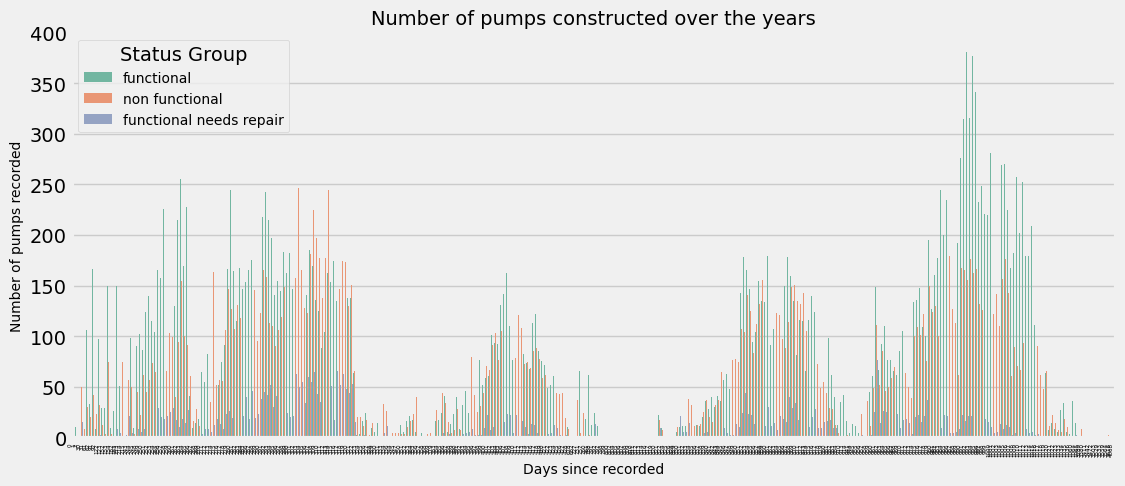

In [38]:
# Definir el tamaño del gráfico
plt.figure(figsize=(12, 5))

# Graficar el conteo de bombas construidas a lo largo de los años, diferenciando por estado del grupo
sns.countplot(x=df_train["days_since_recorded"], hue=df_train["status_group"], palette="Set2")

# Personalizar las etiquetas del eje x
plt.xticks(rotation=90, horizontalalignment='right', fontsize=4)

# Agregar título y etiquetas de los ejes
plt.title("Number of pumps constructed over the years", fontsize=14)
plt.xlabel("Days since recorded", fontsize=10)
plt.ylabel("Number of pumps recorded", fontsize=10)

# Mostrar la leyenda
plt.legend(title="Status Group", fontsize=10)

# Mostrar el gráfico
plt.show()

In [39]:
# Encontrar el valor mínimo y máximo de la columna 'days_since_recorded'
min_value = df_train['days_since_recorded'].min()
max_value = df_train['days_since_recorded'].max()

In [40]:
min_value

0

In [41]:
max_value

4068

Al ser una variable de tipo numérica no será necesaria hacerla *Dummy*

## Modificación de variable: 'construction_year'

**Antes que nada analizemos un poco este atributo**

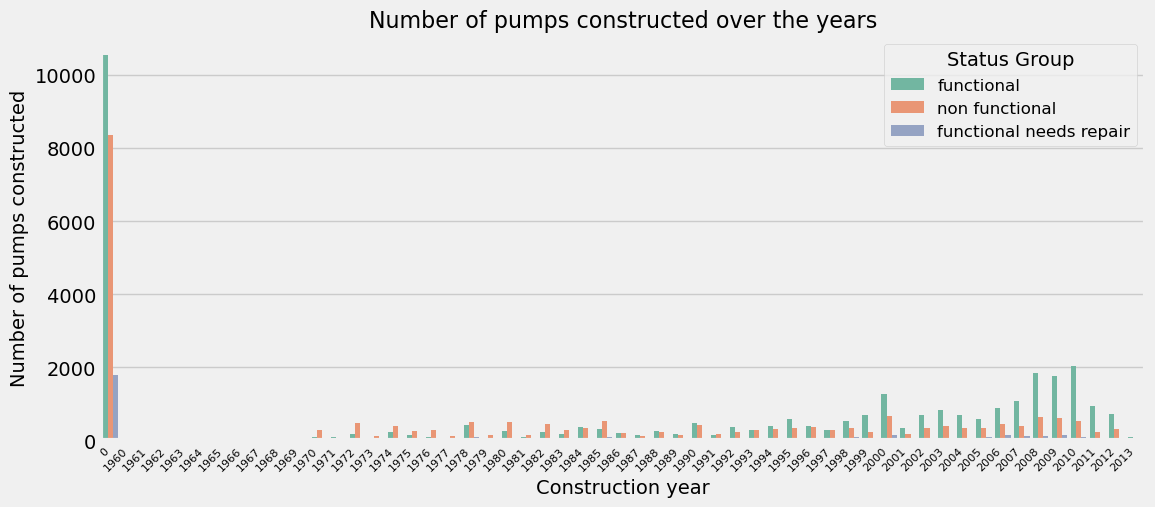

In [42]:
# Definir el tamaño del gráfico
plt.figure(figsize=(12, 5))

# Graficar el conteo de bombas construidas a lo largo de los años, diferenciando por estado del grupo
sns.countplot(x=df_train["construction_year"], hue=df_train["status_group"], palette="Set2")

# Personalizar las etiquetas del eje x
plt.xticks(rotation=45, horizontalalignment='right', fontsize=8)

# Agregar título y etiquetas de los ejes
plt.title("Number of pumps constructed over the years", fontsize=16)
plt.xlabel("Construction year", fontsize=14)
plt.ylabel("Number of pumps constructed", fontsize=14)

# Mostrar la leyenda
plt.legend(title="Status Group", fontsize=12)

# Mostrar el gráfico
plt.show()

En el gráfico de los datos de *df_train['construction_year']* se observa que la variable (**construction_year**) podría influir notablemente en el **'status_group'** , puesto que se observa que antes de 1985 existen más bombas en estado "non functional" que "functional". A partir de ese año pareciera que la diferencia entre  "non functional" y "functional" no es tan grande. Y, desde 1995 y sobre todo a partir de los 2000s el porcentaje de "functional" supera a las "non functional" por mucho. Si bien observamos tambien que hay numerosos registros sin dato (dato=0), vale la pena conservar esa variable de momento ya que por lo dicho antes, podria ser discriminante y significativa a la hora de predecir el estado de funccionamiento de las bombas de agua. 

Por todo lo mencionado, modificaremos la variable construction_year, esto para agrupar los años en rangos más relevantes e intentar darle más significatividad.

In [43]:
# Cambio el construction_year en una variable categorica conteniendo rangos de años.

def construction_wrangler(row):
    if row['construction_year'] >= 1960 and row['construction_year'] < 1970:
        return '1960-1969'
    elif row['construction_year'] >= 1970 and row['construction_year'] < 1980:
        return '1970-1979'
    elif row['construction_year'] >= 1980 and row['construction_year'] < 1986:
        return '1980-1985'
    elif row['construction_year'] >= 1986 and row['construction_year'] < 1992:
        return '1986-1991'
    elif row['construction_year'] >= 1992 and row['construction_year'] < 1998:
        return '1992-1997'
    elif row['construction_year'] >= 1998 and row['construction_year'] < 2002:
        return '1998-2001'
    elif row['construction_year'] >= 2002 and row['construction_year'] < 2006:
        return '2002-2005'
    elif row['construction_year'] >= 2006 and row['construction_year'] < 2010:
        return '2006-2009'
    elif row['construction_year'] >= 2010:
        return '2010-2013'
    else:
        return 'unknown'


**Hice varias pruebas antes de elegir esta distribución ↑↑↑↑↑**

In [44]:
df_train['construction_year'] = df_train.apply(lambda row: construction_wrangler(row), axis=1)

In [45]:
df_train['construction_year'].value_counts()

unknown      20709
2006-2009     8204
2010-2013     5161
1998-2001     4576
2002-2005     4495
1992-1997     4455
1970-1979     4406
1980-1985     4005
1986-1991     2851
1960-1969      538
Name: construction_year, dtype: int64

In [46]:
df_train[['construction_year', 'status_group']].value_counts()

construction_year  status_group           
unknown            functional                 10555
                   non functional              8365
2006-2009          functional                  5577
2010-2013          functional                  3794
1998-2001          functional                  2846
2002-2005          functional                  2802
1970-1979          non functional              2652
1992-1997          functional                  2296
1980-1985          non functional              2254
2006-2009          non functional              2111
1992-1997          non functional              1851
unknown            functional needs repair     1789
1980-1985          functional                  1455
1998-2001          non functional              1423
1970-1979          functional                  1406
2002-2005          non functional              1405
1986-1991          functional                  1372
                   non functional              1276
2010-2013          no

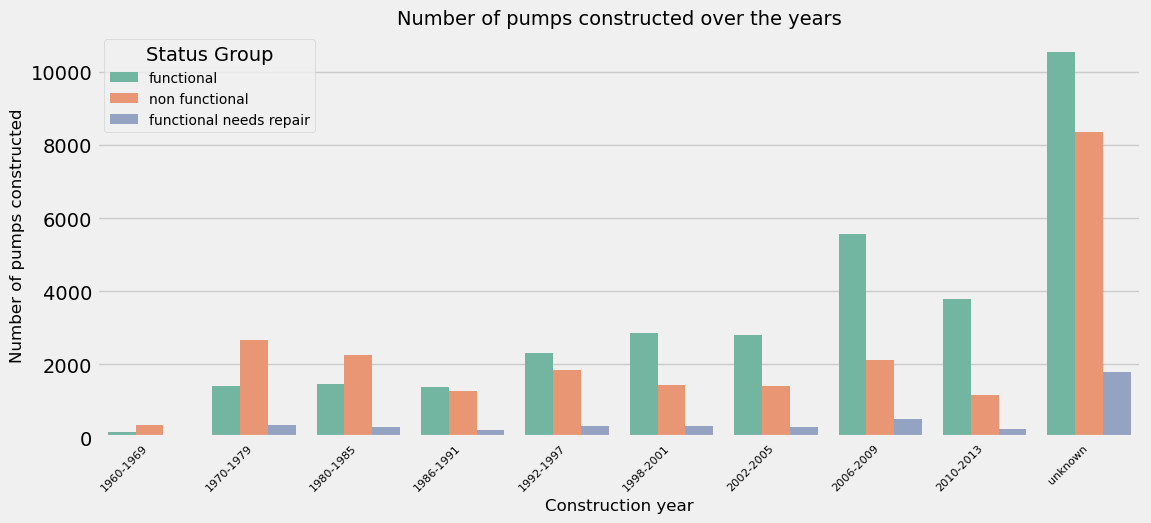

In [47]:
# Definir el tamaño del gráfico
plt.figure(figsize=(12, 5))

# Ordenar los años en orden cronológico
years = sorted(df_train["construction_year"].unique())

# Graficar el conteo de bombas construidas a lo largo de los años, diferenciando por estado del grupo
sns.countplot(x=df_train["construction_year"], hue=df_train["status_group"], palette="Set2", order=years)

# Personalizar las etiquetas del eje x
plt.xticks(rotation=45, horizontalalignment='right', fontsize=8)

# Agregar título y etiquetas de los ejes
plt.title("Number of pumps constructed over the years", fontsize=14)
plt.xlabel("Construction year", fontsize=12)
plt.ylabel("Number of pumps constructed", fontsize=12)

# Mostrar la leyenda
plt.legend(title="Status Group", fontsize=10)

# Mostrar el gráfico
plt.show()

Las bombas construidas recientemente tienen mayor porcentaje de status "functional". El número de bombas que necesitan una reparación no parece muy elevado y sobretodo se mantiene estable con el paso de los años. Todo esto nos indica que este atributo podría ser muy útil a la hora de realizar las predicciones en nuestro modelo. Aunque existan muchas filas que tienen "unknown" como año de construcción. 

In [48]:
df_train.shape

(59400, 41)

## Eliminar una gran cantidad de valores categóricos únicos

La siguiente función calcula y devuelve un diccionario que contiene el número de valores únicos para cada columna categórica en un DataFrame determinado

In [49]:
def count_unique_categorical_values(df_train):

    unique_counts = {}
    for column in df_train.columns:
        if df_train[column].dtype == 'object':  # Compruebe si la columna contiene valores categóricos
            unique_counts[column] = df_train[column].nunique()
    return unique_counts

In [50]:
count_unique_categorical_values(df_train)

{'funder': 1897,
 'installer': 2145,
 'wpt_name': 37400,
 'basin': 9,
 'subvillage': 19287,
 'region': 21,
 'lga': 125,
 'ward': 2092,
 'public_meeting': 2,
 'recorded_by': 1,
 'scheme_management': 12,
 'scheme_name': 2696,
 'permit': 2,
 'construction_year': 10,
 'extraction_type': 18,
 'extraction_type_group': 13,
 'extraction_type_class': 7,
 'management': 12,
 'management_group': 5,
 'payment': 7,
 'payment_type': 7,
 'water_quality': 8,
 'quality_group': 6,
 'quantity': 5,
 'quantity_group': 5,
 'source': 10,
 'source_type': 7,
 'source_class': 3,
 'waterpoint_type': 7,
 'waterpoint_type_group': 6,
 'status_group': 3}

Hay 7 columnas con gran cantidad de valores categoricos ('funder', 'installer','wpt_name', 'subvillage', 'lga', 'ward', 'scheme_name') las cuales ademas de no pueden transformarse en variable numericas, generan tantos valores distintos que no es factible ni realizar agrupación de valores en esa misma variable, ni transformarla en dummies ya que serían demasiados. Estas variables seran entonces las que eliminaremos.

In [51]:
# Eliminar columnas con demasiados valores categóricos únicos
df_train.drop(['funder', 'installer','wpt_name', 'subvillage', 'lga', 'ward', 'scheme_name'], axis=1, inplace=True)

In [52]:
df_train.shape

(59400, 34)

In [53]:
# Check de las columnas
df_train.columns

Index(['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude',
       'num_private', 'basin', 'region', 'region_code', 'district_code',
       'population', 'public_meeting', 'recorded_by', 'scheme_management',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'status_group', 'days_since_recorded'],
      dtype='object')

## Excluir columnas con un único valor

In [54]:
count_unique_categorical_values(df_train)

{'basin': 9,
 'region': 21,
 'public_meeting': 2,
 'recorded_by': 1,
 'scheme_management': 12,
 'permit': 2,
 'construction_year': 10,
 'extraction_type': 18,
 'extraction_type_group': 13,
 'extraction_type_class': 7,
 'management': 12,
 'management_group': 5,
 'payment': 7,
 'payment_type': 7,
 'water_quality': 8,
 'quality_group': 6,
 'quantity': 5,
 'quantity_group': 5,
 'source': 10,
 'source_type': 7,
 'source_class': 3,
 'waterpoint_type': 7,
 'waterpoint_type_group': 6,
 'status_group': 3}

Vemos que la columna *recorded_by* solo tiene un valor, por ello la eliminaremos.

In [55]:
df_train.drop(['recorded_by'], axis=1, inplace=True)

In [56]:
df_train.shape

(59400, 33)

## Excluir columnas que sean copia 1 a 1
 
Por los analisis anteriormente realizados, podemos observar que:
 
**- 'payment_type'** es igual a **'payment'**. Solo mantenemos una variable

**- 'quantity_group'** es igual a **'quantity'**. Solo mantenemos una variable


In [57]:
df_train.drop(['payment_type','quantity_group'], axis=1, inplace=True)

In [58]:
df_train.shape

(59400, 31)

## Excluir columnas muy parecidas

**Existen columnas que son muy parecidas, con valores equivalentes unas con otras o valores agrupados similares**, estas son:


- *'extraction_type'*  ,   *'extraction_type_group'*   y   *'extraction_type_class'*

- *'scheme_management* , *'management'*   y   *'management_group'* (esta ultima es su agrupación)

- *'source'*  , *'source_type'* y *'source_class'* (esta ultima es su agrupación)

- *'waterpoint_type'*   y   *'waterpoint_type_group'*


Para saber cuáles eliminar analizaremos su correlación con la variable respuesta 'status_group'

### Hacemos los gráficos para visualizar mejor estos atributos

### Variables categóricas

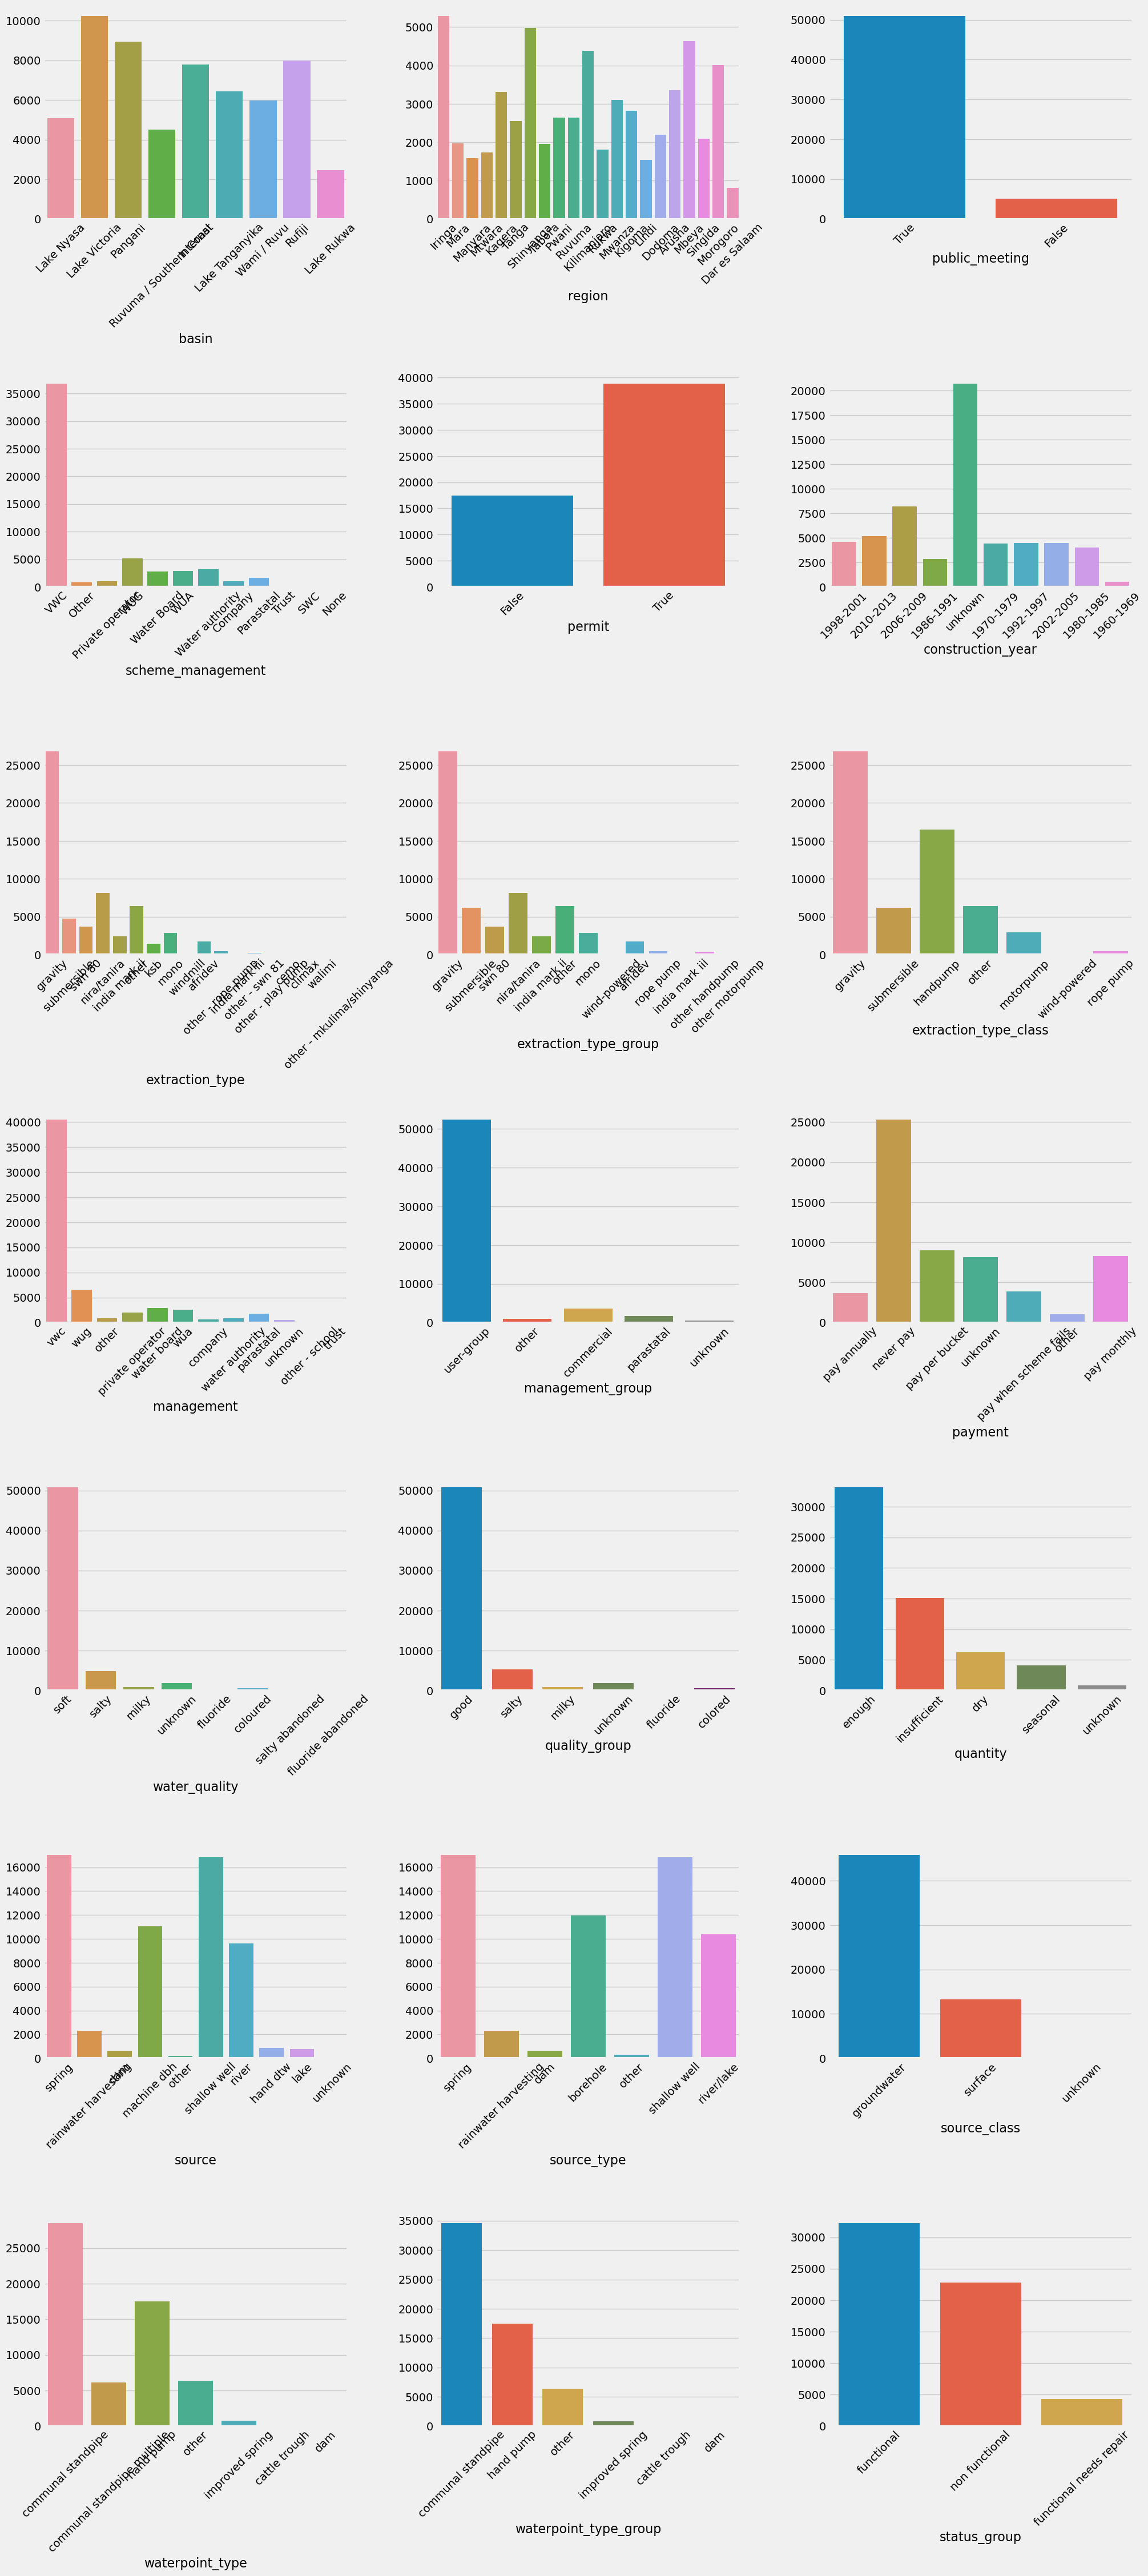

In [59]:
# Seleccionar las columnas categóricas
category_cols = df_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Crear el gráfico
fig, axs = plt.subplots(ncols=3, nrows=7, figsize=(20, 45))
axs = axs.flatten()

index = 0
for k, v in df_train[category_cols].items(): 
    sns.countplot(data=df_train, x=k, ax=axs[index])
    axs[index].set_xlabel(f'{k}', fontsize=16)
    axs[index].set_ylabel('')
    axs[index].tick_params(axis='x', rotation=45)
    index += 1

plt.tight_layout(pad=0.2, w_pad=0.2, h_pad=2.0)
plt.show()

### Variables categoricas vs 'status_group'

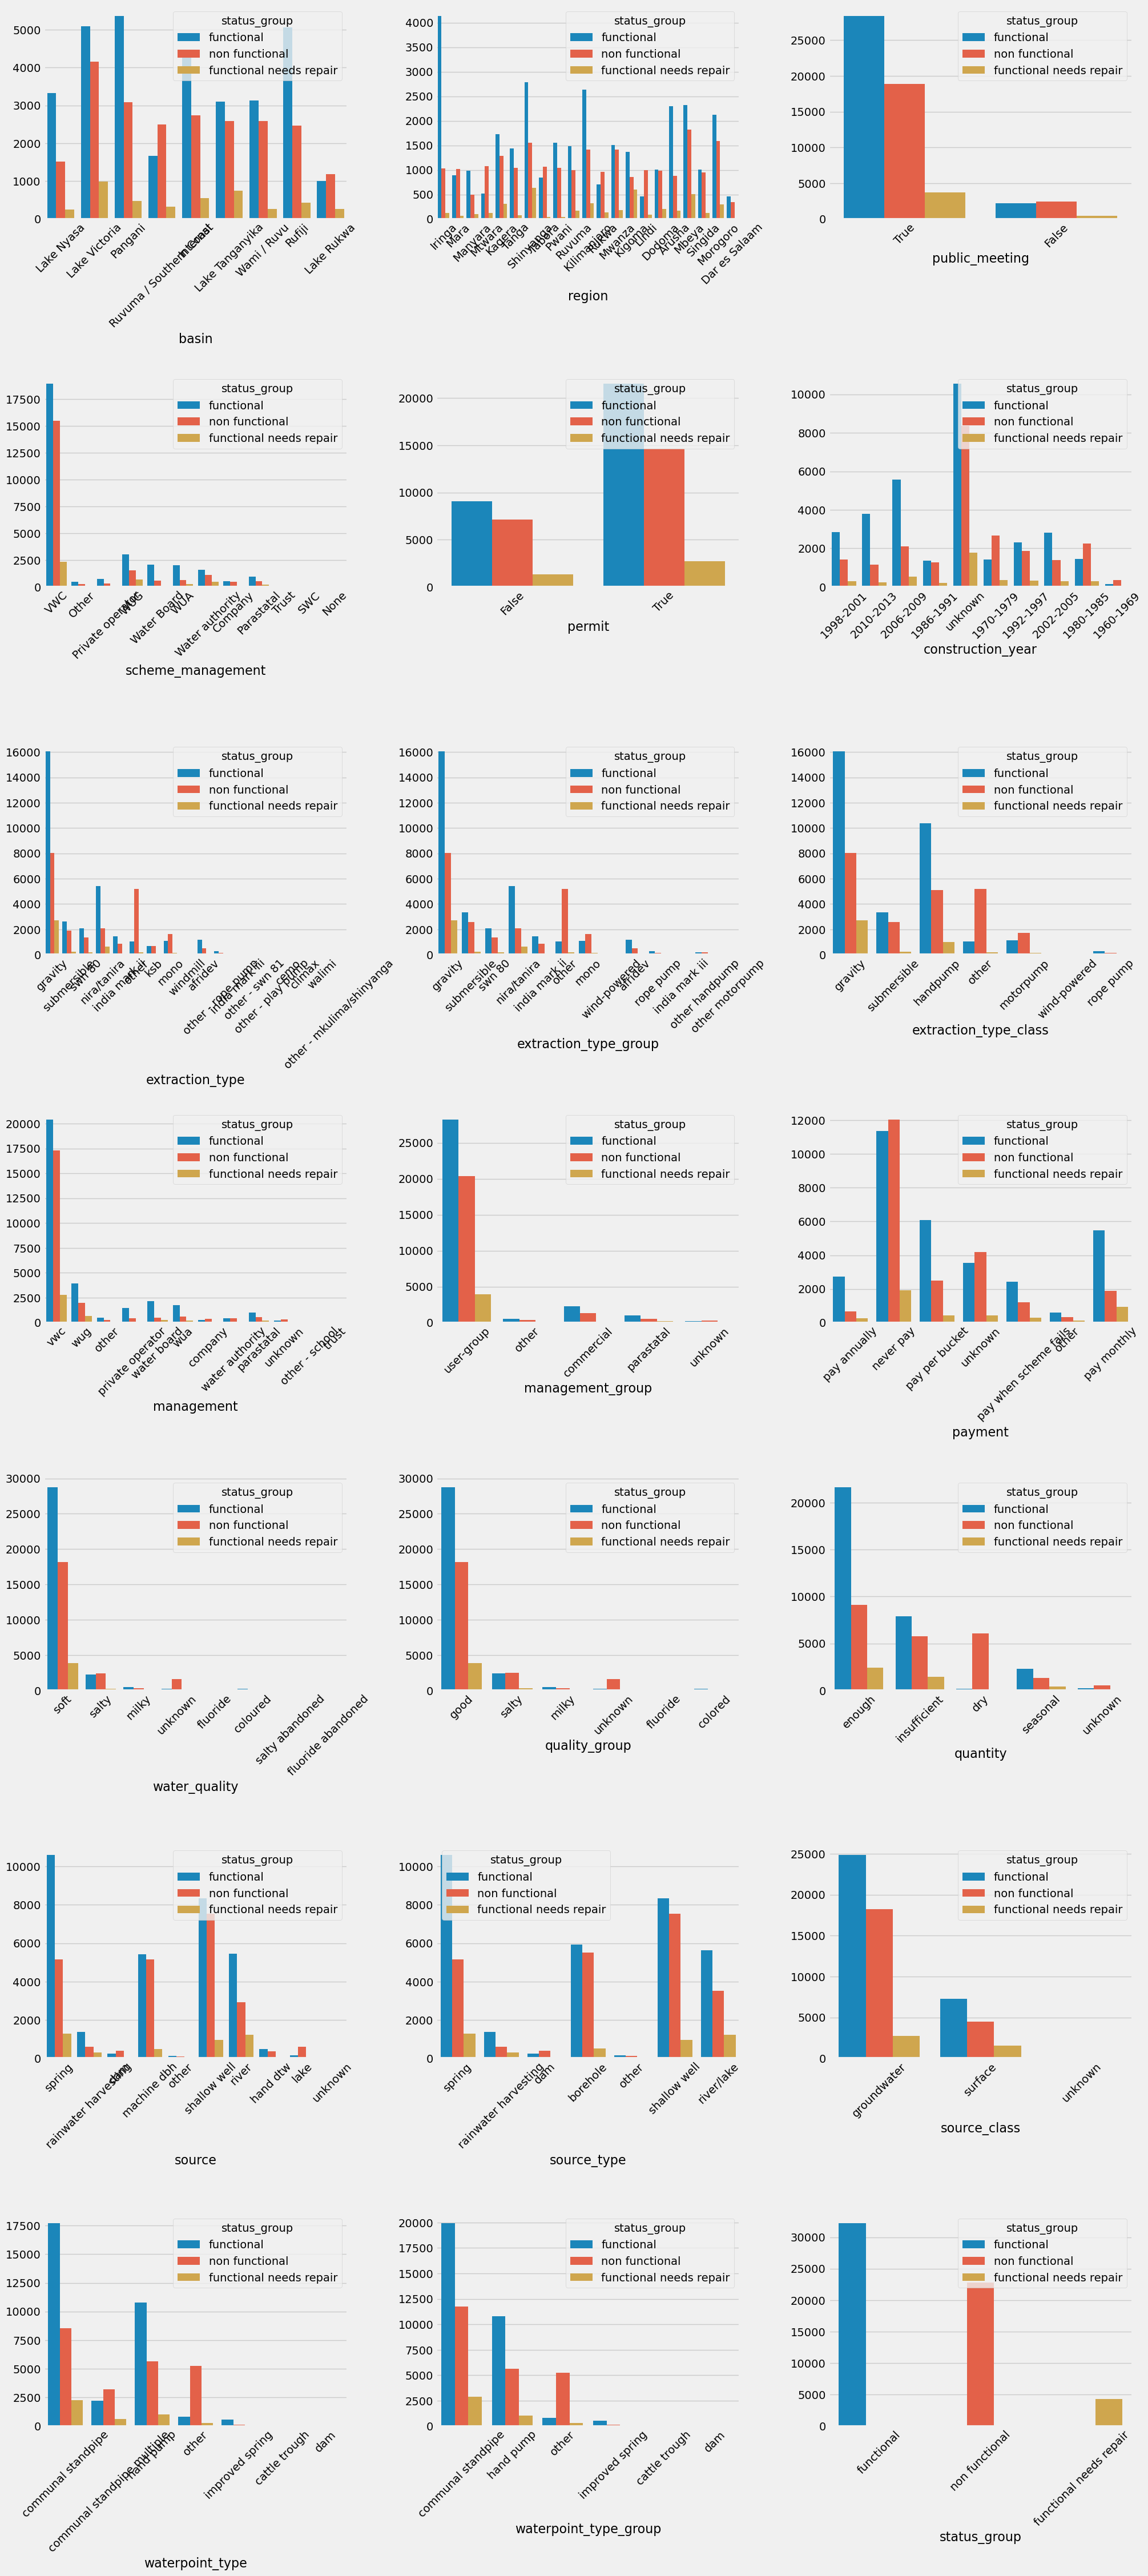

In [60]:
# Crear el gráfico
fig, axs = plt.subplots(ncols=3, nrows=7, figsize=(20, 45))
axs = axs.flatten()

index = 0
for k, v in df_train[category_cols].items(): 
    sns.countplot(data=df_train, x=k, hue=df_train["status_group"], ax=axs[index])
    axs[index].set_xlabel(f'{k}', fontsize=16)
    axs[index].tick_params(axis='x', rotation=45)  # Rotar las etiquetas del eje x
    axs[index].set_ylabel('')
    index += 1

plt.tight_layout(pad=0.2, w_pad=0.2, h_pad=2.0)
plt.show()

## Creación de Dummys para ver la correlación

Buscamos las columnas con tipos 'object'

In [61]:
cols = df_train.select_dtypes(exclude=[np.number])

Visualizamos la lista de las columnas para crear los dummies

In [62]:
list(cols)

['basin',
 'region',
 'public_meeting',
 'scheme_management',
 'permit',
 'construction_year',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'water_quality',
 'quality_group',
 'quantity',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group',
 'status_group']

Obtenemos nuestras variables dummy para características categóricas

In [63]:
dummy_correlation = pd.get_dummies(df_train, columns =['basin',
                                                     'region',
                                                     'public_meeting',
                                                     'scheme_management',
                                                     'permit',
                                                     'construction_year',
                                                     'extraction_type',
                                                     'extraction_type_group',
                                                     'extraction_type_class',
                                                     'management',
                                                     'management_group',
                                                     'payment',
                                                     'water_quality',
                                                     'quality_group',
                                                     'quantity',
                                                     'source',
                                                     'source_type',
                                                     'source_class',
                                                     'waterpoint_type',
                                                     'waterpoint_type_group'])

## Correlación para todas las variables (en Dummys)

Recuerda que **df_correlation** es el data frame que contiene solamente los atributos *id* y *status_group*, siendo este ultimo de tipo numérico.

In [64]:
dummy_correlation.drop(['status_group'],axis=1, inplace=True)

In [65]:
df_correlation2 = dummy_correlation.merge(df_correlation, how='left', on='id')

In [66]:
corr = abs(df_correlation2.corr())
corr[['status_group']].sort_values(by = 'status_group',ascending = False)

,status_group
status_group,1.000000
quantity_dry,0.397962
waterpoint_type_group_other,0.310295
waterpoint_type_other,0.310295
extraction_type_other,0.295936
...,...
region_Dar es Salaam,0.001206
region_Tanga,0.000574
source_class_unknown,0.000300
source_type_other,0.000300


**Guardemos los resultados de esta correlación en un csv para apreciarlos mejor.**

Aunque tambien podriamos usar:

pd.set_option('display.max_rows', None)

Para apreciar todos los datos.

In [67]:
resultados_correlacion = corr[['status_group']].sort_values(by='status_group', ascending=False)
# Guardar los resultados en un archivo CSV
resultados_correlacion.to_csv('resultados_correlacion.csv', index=True)

Observamos que:

- Los valores de ***'waterpoint_type'*** tienen más correlacion que los de 'waterpoint_type_group'. **Eliminamos 'waterpoint_type_group'**.

- Los valores de ***'extraction_type'*** tienen más correlacion que los de 'extraction_type_group' y 'extraction_type_class'. **Eliminamos *'extraction_type_group'* y *'extraction_type_class'***.


- Los valores de ***'source'*** tienen más correlacion que los de *'source_type'*. **Eliminamos *'source_type'* . Eliminamos tambien *'source_class***, pues es una agrupación de *'source'*

-  Los valores de ***'management'*** tienen más correlacion que los de *'scheme_management*. **Eliminamos *'scheme_management*. Eliminamos también *'management_group'***, pues es una agrupación de *'management'*

### Eliminemos los valores mencionados

In [68]:
df_train.drop([ 'waterpoint_type_group','extraction_type_group','extraction_type_class', 'source_type', 'source_class', 'scheme_management','management_group'], axis=1, inplace=True)

In [69]:
df_train.shape

(59400, 24)

## Analizar los valores faltantes y modificarlos (si es necesario)

Veamos si aún despues de este preprocesado aún existen atributos con muchos valores faltantes.

In [70]:
# Valores faltantes por columna
df_train.isnull().sum()

id                        0
amount_tsh                0
gps_height                0
longitude                 0
latitude                  0
num_private               0
basin                     0
region                    0
region_code               0
district_code             0
population                0
public_meeting         3334
permit                 3056
construction_year         0
extraction_type           0
management                0
payment                   0
water_quality             0
quality_group             0
quantity                  0
source                    0
waterpoint_type           0
status_group              0
days_since_recorded       0
dtype: int64

Son dos variables, *public_meeting* y *permit* que tienen más de 3000 registros con valores faltantes.

In [71]:
df_train.dtypes

id                       int64
amount_tsh             float64
gps_height               int64
longitude              float64
latitude               float64
num_private              int64
basin                   object
region                  object
region_code              int64
district_code            int64
population               int64
public_meeting          object
permit                  object
construction_year       object
extraction_type         object
management              object
payment                 object
water_quality           object
quality_group           object
quantity                object
source                  object
waterpoint_type         object
status_group            object
days_since_recorded      int32
dtype: object

Veamos su valores unicos

In [72]:
df_train['public_meeting'].unique()

array([True, nan, False], dtype=object)

In [73]:
df_train['permit'].unique()

array([False, True, nan], dtype=object)

Estos dos atibutos podrían ser tratados como binarios, pero al haber muchos valores inexistentes, tendriamos que completar esos valores, que sea de tipo objeto y pasarlos a Dummys posteriormente.

In [74]:
# Reemplazar los valores NaN en la columna 'permit' y  'public_meeting' con 'Other'
df_train['permit'].fillna('Other', inplace=True)
df_train['public_meeting'].fillna('Other', inplace=True)

**Verificamos los valores únicos después de la modificación**

In [75]:
df_train['permit'].unique()

array([False, True, 'Other'], dtype=object)

In [76]:
df_train['public_meeting'].unique()

array([True, 'Other', False], dtype=object)

In [77]:
df_train.shape

(59400, 24)

In [78]:
# Check de las columnas y los tipos de datos
df_train.dtypes

id                       int64
amount_tsh             float64
gps_height               int64
longitude              float64
latitude               float64
num_private              int64
basin                   object
region                  object
region_code              int64
district_code            int64
population               int64
public_meeting          object
permit                  object
construction_year       object
extraction_type         object
management              object
payment                 object
water_quality           object
quality_group           object
quantity                object
source                  object
waterpoint_type         object
status_group            object
days_since_recorded      int32
dtype: object

**Guardemos el df_train, para hacer pruebas posteriormente**

In [79]:
df_train.to_csv('df_train.csv', index=False)

## Creación de Dummys para el: clean_train.csv

El **clean_train.csv** será la data que usaremos para realizar los modelos.

Buscamos las columnas con tipos 'object'

In [80]:
cols = df_train.select_dtypes(exclude=[np.number])

Visualizamos la lista de las columnas para crear los dummies

In [81]:
list(cols)

['basin',
 'region',
 'public_meeting',
 'permit',
 'construction_year',
 'extraction_type',
 'management',
 'payment',
 'water_quality',
 'quality_group',
 'quantity',
 'source',
 'waterpoint_type',
 'status_group']

Obtenemos nuestras variables dummy para características categóricas (ignoramos *status_group* pues se trata de nuestra variable respuesta)

In [82]:
dummy_df_train = pd.get_dummies(df_train, columns =['basin',
                                                     'region',
                                                     'public_meeting',
                                                     'permit',
                                                     'construction_year',
                                                     'extraction_type',
                                                     'management',
                                                     'payment',
                                                     'water_quality',
                                                     'quality_group',
                                                     'quantity',
                                                     'source',
                                                     'waterpoint_type'])

In [83]:
# Check for new columns
dummy_df_train.columns

Index(['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude',
       'num_private', 'region_code', 'district_code', 'population',
       'status_group',
       ...
       'source_shallow well', 'source_spring', 'source_unknown',
       'waterpoint_type_cattle trough', 'waterpoint_type_communal standpipe',
       'waterpoint_type_communal standpipe multiple', 'waterpoint_type_dam',
       'waterpoint_type_hand pump', 'waterpoint_type_improved spring',
       'waterpoint_type_other'],
      dtype='object', length=130)

In [84]:
dummy_df_train.shape

(59400, 130)

Guardamos nuestra data limpia para hacer diferentes pruebas

In [85]:
dummy_df_train.to_csv('clean_train.csv', index=False)

# II. Datos de Test

## Carguemos los datos

In [86]:
df_test = pd.read_csv("Test_values.csv")

In [87]:
df_test.shape

(14850, 40)

## Comprobemos si las columnas y/o filas de df_test son las mismas que las de df

Los datos de **df_test** deben tener la misma estrutura que los datos de **df_train** (a excepción del status_group, por ello, debería ser como **df**), esto para que los modelos aplicados posteriormente puedan funcionar. Por ello, seguiremos la misma metodología para tratarlos.

**Veamos si hay alguna coincidencia de id**

In [88]:
print('Coincidencia ids train/test:\n', df_test['id'].isin(df['id']).value_counts())

Coincidencia ids train/test:
 False    14850
Name: id, dtype: int64


No hay ninguna coincidencia de ids.

**Veamos si las columnas son las mismas**

In [89]:
print('Comprobamos si las columnas son las mismas: \n ', df_test.columns.isin(df.columns))

Comprobamos si las columnas son las mismas: 
  [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


Podemos ver que las columnas son las mismas, por lo que se puede hacer el mismo tratamiento de los datos.

## Limpieza y preprocesado de los datos de Test

### Modificación de variable: 'date_recorded' a 'days_since_recorded'

In [90]:
# Convertir la columna a datetime
df_test['date_recorded'] = pd.to_datetime(df_test['date_recorded'])

In [91]:
df_test.dtypes

id                                int64
amount_tsh                      float64
date_recorded            datetime64[ns]
funder                           object
gps_height                        int64
installer                        object
longitude                       float64
latitude                        float64
wpt_name                         object
num_private                       int64
basin                            object
subvillage                       object
region                           object
region_code                       int64
district_code                     int64
lga                              object
ward                             object
population                        int64
public_meeting                   object
recorded_by                      object
scheme_management                object
scheme_name                      object
permit                           object
construction_year                 int64
extraction_type                  object


In [92]:
# Encontrar el valor mínimo y máximo de la columna 'date_recorded'
min_value = df_test['date_recorded'].min()
max_value = df_test['date_recorded'].max()

In [93]:
min_value

Timestamp('2001-03-26 00:00:00')

In [94]:
max_value

Timestamp('2013-12-03 00:00:00')

**Podemos sacar mayor provecho a este atributo si lo convertimos a un atributo de tipo numerico**

Los datos más recientes son del 12 de marzo de 2013, por ello usaremos esa fecha para crear una nueva variable llamada: days_since_recorded

In [95]:
df_test['days_since_recorded'] = pd.datetime(2013, 12, 3) - pd.to_datetime(df_test.date_recorded)
df_test['days_since_recorded'] = df_test['days_since_recorded'].astype('timedelta64[D]').astype(int)

In [96]:
df_test.dtypes

id                                int64
amount_tsh                      float64
date_recorded            datetime64[ns]
funder                           object
gps_height                        int64
installer                        object
longitude                       float64
latitude                        float64
wpt_name                         object
num_private                       int64
basin                            object
subvillage                       object
region                           object
region_code                       int64
district_code                     int64
lga                              object
ward                             object
population                        int64
public_meeting                   object
recorded_by                      object
scheme_management                object
scheme_name                      object
permit                           object
construction_year                 int64
extraction_type                  object


In [97]:
df_test.shape

(14850, 41)

**Eliminamos la variable *date_recorded*, pues la hemos tranformado, y la nueva variable *days_since_recorded* nos dará su información.**

In [98]:
df_test.drop(['date_recorded'], axis=1, inplace=True)

In [99]:
df_test.shape

(14850, 40)

In [100]:
# Encontrar el valor mínimo y máximo de la columna 'days_since_recorded'
min_value = df_test['days_since_recorded'].min()
max_value = df_test['days_since_recorded'].max()

In [101]:
min_value

0

In [102]:
max_value

4635

Al ser una variable de tipo numérica no será necesaria hacerla *Dummy*

### Modificación de variable: 'construction_year'

In [103]:
# Encontrar el valor mínimo y máximo de la columna 'days_since_recorded'
min_value = df_test['construction_year'].min()
max_value = df_test['construction_year'].max()

In [104]:
min_value

0

In [105]:
max_value

2013

In [106]:
# Cambie el construction_year para hacer los rangos más relevantes.

def construction_wrangler(row):
    if row['construction_year'] >= 1960 and row['construction_year'] < 1970:
        return '1960-1969'
    elif row['construction_year'] >= 1970 and row['construction_year'] < 1980:
        return '1970-1979'
    elif row['construction_year'] >= 1980 and row['construction_year'] < 1986:
        return '1980-1985'
    elif row['construction_year'] >= 1986 and row['construction_year'] < 1992:
        return '1986-1991'
    elif row['construction_year'] >= 1992 and row['construction_year'] < 1998:
        return '1992-1997'
    elif row['construction_year'] >= 1998 and row['construction_year'] < 2002:
        return '1998-2001'
    elif row['construction_year'] >= 2002 and row['construction_year'] < 2006:
        return '2002-2005'
    elif row['construction_year'] >= 2006 and row['construction_year'] < 2010:
        return '2006-2009'
    elif row['construction_year'] >= 2010:
        return '2010-2013'
    else:
        return 'unknown'


In [107]:
df_test['construction_year'] = df_test.apply(lambda row: construction_wrangler(row), axis=1)

In [108]:
df_test['construction_year'].value_counts()

unknown      5260
2006-2009    2087
2010-2013    1300
1992-1997    1161
2002-2005    1119
1998-2001    1094
1970-1979    1042
1980-1985     958
1986-1991     708
1960-1969     121
Name: construction_year, dtype: int64

### Eliminar una gran cantidad de valores categóricos únicos

In [109]:
# Eliminar columnas con demasiados valores categóricos únicos
df_test.drop(['funder', 'installer','wpt_name', 'subvillage', 'lga', 'ward', 'scheme_name'], axis=1, inplace=True)

In [110]:
df_test.shape

(14850, 33)

### Excluir columnas con un único valor

In [111]:
df_test.drop(['recorded_by'], axis=1, inplace=True)

In [112]:
df_test.shape

(14850, 32)

### Excluir columnas que sean copia 1 a 1
 
Por los analisis anteriormente realizados, podemos observar que:
 
**- 'payment_type'** es igual a **'payment'**. Solo mantenemos una variable

**- 'quantity_group'** es igual a **'quantity'**. Solo mantenemos una variable


In [113]:
df_test.drop(['payment_type','quantity_group'], axis=1, inplace=True)

In [114]:
df_test.shape

(14850, 30)

### Excluir columnas muy parecidas

**Existen columnas que son muy parecidas, con valores equivalentes unas con otras o valures agrupados similares**, estas son:


- *'extraction_type'*  ,   *'extraction_type_group'*   y   *'extraction_type_class'*

- *'scheme_management* , *'management'*   y   *'management_group'* (esta ultima es su agrupación)

- *'source'*  , *'source_type'* y *'source_class'* (esta ultima es su agrupación)

- *'waterpoint_type'*   y   *'waterpoint_type_group'*


Despues de analizar su correlación con la variable respuesta 'status_group' en df_train se decidió:


- Los valores de ***'waterpoint_type'*** tienen más correlacion que los de 'waterpoint_type_group'. **Eliminamos 'waterpoint_type_group'**.

- Los valores de ***'extraction_type'*** tienen más correlacion que los de 'extraction_type_group' y 'extraction_type_class'. **Eliminamos *'extraction_type_group'* y *'extraction_type_class'***.


- Los valores de ***'source'*** tienen más correlacion que los de *'source_type'*. **Eliminamos *'source_type'* . Eliminamos tambien *'source_class***, pues es una agrupación de *'source'*

-  Los valores de ***'management'*** tienen más correlacion que los de *'scheme_management*. **Eliminamos *'scheme_management*. Eliminamos también *'management_group'***, pues es una agrupación de *'management'*

In [115]:
df_test.drop([ 'waterpoint_type_group','extraction_type_group','extraction_type_class', 'source_type', 'source_class', 'scheme_management','management_group'], axis=1, inplace=True)

In [116]:
df_test.shape

(14850, 23)

### Analizar los valores faltantes y modificarlos (si es necesario)

Veamos si aún despues de este preprocesado aún existen atributos con muchos valores faltantes.

In [117]:
# Valores faltantes por columna
df_test.isnull().sum()

id                       0
amount_tsh               0
gps_height               0
longitude                0
latitude                 0
num_private              0
basin                    0
region                   0
region_code              0
district_code            0
population               0
public_meeting         821
permit                 737
construction_year        0
extraction_type          0
management               0
payment                  0
water_quality            0
quality_group            0
quantity                 0
source                   0
waterpoint_type          0
days_since_recorded      0
dtype: int64

Veamos sus valores unicos

In [118]:
df_test['public_meeting'].unique()

array([True, nan, False], dtype=object)

In [119]:
df_test['permit'].unique()

array([True, nan, False], dtype=object)

Estos dos atributos podrían ser tratados como binarios, pero al haber muchos valores inexistentes, tendriamos que completar esos valores, que sea de tipo objeto y pasarlos a Dummys posteriormente.

In [120]:
# Reemplazar los valores NaN en la columna 'permit' y  'public_meeting' con 'Other'
df_test['permit'].fillna('Other', inplace=True)
df_test['public_meeting'].fillna('Other', inplace=True)

**Verificamos los valores únicos después de la modificación**

In [121]:
df_test['permit'].unique()

array([True, 'Other', False], dtype=object)

In [122]:
df_test['public_meeting'].unique()

array([True, 'Other', False], dtype=object)

In [123]:
df_test.shape

(14850, 23)

In [124]:
# Check de las columnas y los tipos de datos
df_test.dtypes

id                       int64
amount_tsh             float64
gps_height               int64
longitude              float64
latitude               float64
num_private              int64
basin                   object
region                  object
region_code              int64
district_code            int64
population               int64
public_meeting          object
permit                  object
construction_year       object
extraction_type         object
management              object
payment                 object
water_quality           object
quality_group           object
quantity                object
source                  object
waterpoint_type         object
days_since_recorded      int32
dtype: object

**Guardemos el una vez más el df_train, para hacer pruebas posteriormente**

In [125]:
df_test.to_csv('df_test.csv', index=False)

## Creación de Dummys para el: clean_test.csv

El **clean_test.csv** será la data que usaremos para realizar los modelos.

Buscamos las columnas con tipos 'object'

In [126]:
cols = df_test.select_dtypes(exclude=[np.number])

Visualizamos la lista de las columnas para crear los dummies

In [127]:
list(cols)

['basin',
 'region',
 'public_meeting',
 'permit',
 'construction_year',
 'extraction_type',
 'management',
 'payment',
 'water_quality',
 'quality_group',
 'quantity',
 'source',
 'waterpoint_type']

Obtenemos nuestras variables dummy para características categóricas.

In [128]:
dummy_df_test = pd.get_dummies(df_test, columns =['basin',
                                                     'region',
                                                     'public_meeting',
                                                     'permit',
                                                     'construction_year',
                                                     'extraction_type',
                                                     'management',
                                                     'payment',
                                                     'water_quality',
                                                     'quality_group',
                                                     'quantity',
                                                     'source',
                                                     'waterpoint_type'])

In [129]:
# Check for new columns
dummy_df_test.columns

Index(['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude',
       'num_private', 'region_code', 'district_code', 'population',
       'days_since_recorded',
       ...
       'source_shallow well', 'source_spring', 'source_unknown',
       'waterpoint_type_cattle trough', 'waterpoint_type_communal standpipe',
       'waterpoint_type_communal standpipe multiple', 'waterpoint_type_dam',
       'waterpoint_type_hand pump', 'waterpoint_type_improved spring',
       'waterpoint_type_other'],
      dtype='object', length=128)

In [130]:
dummy_df_test.shape

(14850, 128)

Guardamos nuestra data limpia para hacer diferentes pruebas

In [131]:
dummy_df_test.to_csv('clean_test.csv', index=False)

In [132]:
dummy_df_train.shape

(59400, 130)

In [133]:
dummy_df_train.columns.difference(dummy_df_test.columns)

Index(['extraction_type_other - mkulima/shinyanga', 'status_group'], dtype='object')

Posteriormente se eliminará esta columna (al probar los modelos)

# III. Alguna prueba adicional de limpieza de datos

## Con agrupación del atributo days_since_recorded

Haremos esto para probar si agrupando los 'days_since_recorded' se obtiene un mejor resultado en el modelo.

**Spoiler: NO**

Pero igual dejo el código

Cargamos nuestros datos guardados antes de aplicar los *Dummys*

In [134]:
dummy_df_train.columns.difference(dummy_df_test.columns)

Index(['extraction_type_other - mkulima/shinyanga', 'status_group'], dtype='object')

In [135]:
df_test=pd.read_csv('df_test.csv')
df_train=pd.read_csv('df_train.csv')

### Ahora analizemos un poco a days_since_recorded

**Para df_train**

In [136]:
# Encontrar el valor mínimo y máximo de la columna 'days_since_recorded'
min_value = df_train['days_since_recorded'].min()
max_value = df_train['days_since_recorded'].max()

In [137]:
min_value

0

In [138]:
max_value

4068

**Para df_test**

In [139]:
# Encontrar el valor mínimo y máximo de la columna 'days_since_recorded'
min_value = df_test['days_since_recorded'].min()
max_value = df_test['days_since_recorded'].max()

In [140]:
min_value

0

In [141]:
max_value

4635

Con la información que proporciona el código anterior modificaremos la columna **days_since_recorded**. Conociendo los valores mínimos y máximos,  se diseñará una función para modificar dicha columna (days_since_recorded). Esto con el fin de hacerlas más representativas.

### Función para modificar la columna 'days_since_recorded'

In [142]:
# Esto se hace para reducir el número de columnas Dummy más adelante

def days_since_recorded(row):
    if row['days_since_recorded'] >= 0 and row['days_since_recorded'] < 500:
        return '0-499'
    elif row['days_since_recorded'] >= 500 and row['days_since_recorded'] < 1000:
        return '500-999'
    elif row['days_since_recorded'] >= 1000 and row['days_since_recorded'] < 1500:
        return '1000-1499'
    elif row['days_since_recorded'] >= 1500 and row['days_since_recorded'] < 2000:
        return '1500-1999'
    elif row['days_since_recorded'] >= 2000 and row['days_since_recorded'] < 2500:
        return '2000-2499'
    elif row['days_since_recorded'] >= 2500 and row['days_since_recorded'] < 3000:
        return '2500-2999'
    elif row['days_since_recorded'] >= 3000 and row['days_since_recorded'] < 3500:
        return '3000-3499'
    elif row['days_since_recorded'] >= 3500 and row['days_since_recorded'] < 4000:
        return '3500-3999'
    elif row['days_since_recorded'] >= 4000:
        return '>4000'
    else:
        return 'unknown'

Se hace solo hasta **>4000** debido a que en df_train solo existe hasta ese rango (4068)

In [143]:
df_train['days_since_recorded'] = df_train.apply(lambda row: days_since_recorded(row), axis=1)

In [144]:
df_test['days_since_recorded'] = df_test.apply(lambda row: days_since_recorded(row), axis=1)

### Observamos el resultado de nuestra función:

**Para df_train**

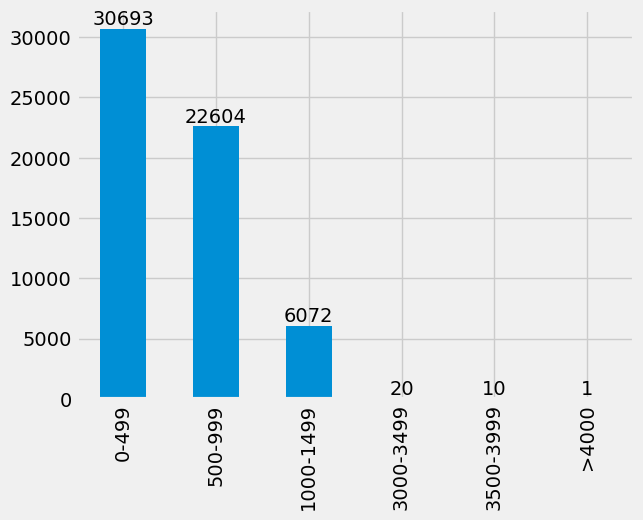

In [145]:
value_counts = df_train['days_since_recorded'].value_counts()
ax = value_counts.plot(kind='bar')
# Agregar el número de observaciones a cada barra
for i, count in enumerate(value_counts):
    ax.text(i, count, str(count), ha='center', va='bottom')

In [146]:
df_train.head()

,id,amount_tsh,gps_height,longitude,latitude,num_private,basin,region,region_code,district_code,...,extraction_type,management,payment,water_quality,quality_group,quantity,source,waterpoint_type,status_group,days_since_recorded
0,69572,6000.0,1390,34.938093,-9.856322,0,Lake Nyasa,Iringa,11,5,...,gravity,vwc,pay annually,soft,good,enough,spring,communal standpipe,functional,500-999
1,8776,0.0,1399,34.698766,-2.147466,0,Lake Victoria,Mara,20,2,...,gravity,wug,never pay,soft,good,insufficient,rainwater harvesting,communal standpipe,functional,0-499
2,34310,25.0,686,37.460664,-3.821329,0,Pangani,Manyara,21,4,...,gravity,vwc,pay per bucket,soft,good,enough,dam,communal standpipe multiple,functional,0-499
3,67743,0.0,263,38.486161,-11.155298,0,Ruvuma / Southern Coast,Mtwara,90,63,...,submersible,vwc,never pay,soft,good,dry,machine dbh,communal standpipe multiple,non functional,0-499
4,19728,0.0,0,31.130847,-1.825359,0,Lake Victoria,Kagera,18,1,...,gravity,other,never pay,soft,good,seasonal,rainwater harvesting,communal standpipe,functional,500-999


In [147]:
df_train.shape

(59400, 24)

**Para df_test**

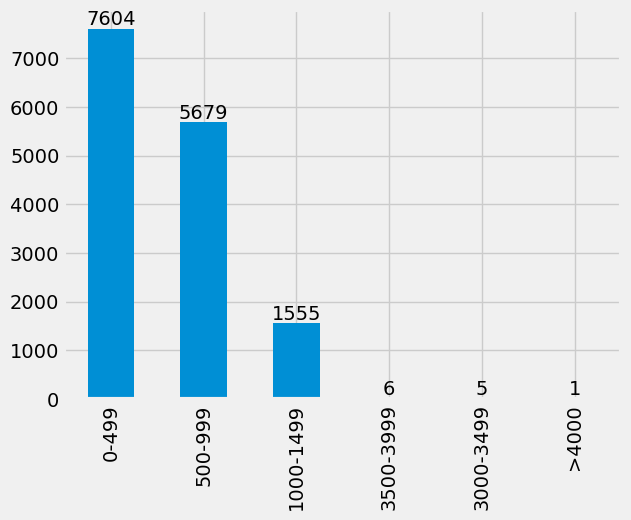

In [148]:
value_counts = df_test['days_since_recorded'].value_counts()
ax = value_counts.plot(kind='bar')
# Agregar el número de observaciones a cada barra
for i, count in enumerate(value_counts):
    ax.text(i, count, str(count), ha='center', va='bottom')

In [149]:
df_test.head()

,id,amount_tsh,gps_height,longitude,latitude,num_private,basin,region,region_code,district_code,...,construction_year,extraction_type,management,payment,water_quality,quality_group,quantity,source,waterpoint_type,days_since_recorded
0,50785,0.0,1996,35.290799,-4.059696,0,Internal,Manyara,21,3,...,2010-2013,other,parastatal,never pay,soft,good,seasonal,rainwater harvesting,other,0-499
1,51630,0.0,1569,36.656709,-3.309214,0,Pangani,Arusha,2,2,...,1998-2001,gravity,vwc,never pay,soft,good,insufficient,spring,communal standpipe,0-499
2,17168,0.0,1567,34.767863,-5.004344,0,Internal,Singida,13,2,...,2010-2013,other,vwc,never pay,soft,good,insufficient,rainwater harvesting,other,0-499
3,45559,0.0,267,38.058046,-9.418672,0,Ruvuma / Southern Coast,Lindi,80,43,...,1986-1991,other,vwc,unknown,soft,good,dry,shallow well,other,0-499
4,49871,500.0,1260,35.006123,-10.950412,0,Ruvuma / Southern Coast,Ruvuma,10,3,...,1998-2001,gravity,water board,pay monthly,soft,good,enough,spring,communal standpipe,0-499


In [150]:
df_test.shape

(14850, 23)

## Creación de Dummys para el: clean_train1.csv y clean_test1.csv

El **clean_train1.csv y clean_test1.csv** será otra data que usaremos para realizar los modelos.

Buscamos las columnas con tipos 'object' (usamos cualquiera pues tienen las mismas columnas, a excepción del status_group)

In [151]:
cols = df_test.select_dtypes(exclude=[np.number])

Visualizamos la lista de las columnas para crear los dummies

In [152]:
list(cols)

['basin',
 'region',
 'public_meeting',
 'permit',
 'construction_year',
 'extraction_type',
 'management',
 'payment',
 'water_quality',
 'quality_group',
 'quantity',
 'source',
 'waterpoint_type',
 'days_since_recorded']

Obtenemos nuestras variables dummy para características categóricas.

**Para Test**

In [153]:
dummy_df_test1 = pd.get_dummies(df_test, columns =['basin',
                                                 'region',
                                                 'public_meeting',
                                                 'permit',
                                                 'construction_year',
                                                 'extraction_type',
                                                 'management',
                                                 'payment',
                                                 'water_quality',
                                                 'quality_group',
                                                 'quantity',
                                                 'source',
                                                 'waterpoint_type',
                                                 'days_since_recorded'])

In [154]:
# Check for new columns
dummy_df_test1.columns

Index(['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude',
       'num_private', 'region_code', 'district_code', 'population',
       'basin_Internal',
       ...
       'waterpoint_type_dam', 'waterpoint_type_hand pump',
       'waterpoint_type_improved spring', 'waterpoint_type_other',
       'days_since_recorded_0-499', 'days_since_recorded_1000-1499',
       'days_since_recorded_3000-3499', 'days_since_recorded_3500-3999',
       'days_since_recorded_500-999', 'days_since_recorded_>4000'],
      dtype='object', length=133)

In [155]:
dummy_df_test1.shape

(14850, 133)

Guardamos nuestra data limpia para hacer diferentes pruebas

In [156]:
dummy_df_test1.to_csv('clean_test1.csv', index=False)

**Para Train**

In [157]:
dummy_df_train1 = pd.get_dummies(df_train, columns =['basin',
                                                 'region',
                                                 'public_meeting',
                                                 'permit',
                                                 'construction_year',
                                                 'extraction_type',
                                                 'management',
                                                 'payment',
                                                 'water_quality',
                                                 'quality_group',
                                                 'quantity',
                                                 'source',
                                                 'waterpoint_type',
                                                 'days_since_recorded'])

In [158]:
# Check for new columns
dummy_df_train1.columns

Index(['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude',
       'num_private', 'region_code', 'district_code', 'population',
       'status_group',
       ...
       'waterpoint_type_dam', 'waterpoint_type_hand pump',
       'waterpoint_type_improved spring', 'waterpoint_type_other',
       'days_since_recorded_0-499', 'days_since_recorded_1000-1499',
       'days_since_recorded_3000-3499', 'days_since_recorded_3500-3999',
       'days_since_recorded_500-999', 'days_since_recorded_>4000'],
      dtype='object', length=135)

In [159]:
dummy_df_train1.shape

(59400, 135)

Guardamos nuestra data limpia para hacer diferentes pruebas

In [160]:
dummy_df_train1.to_csv('clean_train1.csv', index=False)

Veamos las diferencias

In [161]:
dummy_df_train1.columns.difference(dummy_df_test1.columns)

Index(['extraction_type_other - mkulima/shinyanga', 'status_group'], dtype='object')

Posteriormente se eliminará esta columna (al provar los modelos)

### SPOILER

**Despues de probar 'clean_train1.csv' y 'clean_test1.csv', se observaron peores resultados, por ello estas pruebas no se pondran aquí, esto con el fin de tener un notebook más limpio.**

# IV. LOS MODELOS

Se probaron más modelos sin embargo aqui se mostrarán solo tres

## Carga los datos de nuestros csv

In [162]:
df = pd.read_csv('clean_train.csv')
df_test = pd.read_csv('clean_test.csv')

### Una pequeña visualización de los mismos

In [163]:
df.head()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,status_group,...,source_shallow well,source_spring,source_unknown,waterpoint_type_cattle trough,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
0,69572,6000.0,1390,34.938093,-9.856322,0,11,5,109,functional,...,0,1,0,0,1,0,0,0,0,0
1,8776,0.0,1399,34.698766,-2.147466,0,20,2,280,functional,...,0,0,0,0,1,0,0,0,0,0
2,34310,25.0,686,37.460664,-3.821329,0,21,4,250,functional,...,0,0,0,0,0,1,0,0,0,0
3,67743,0.0,263,38.486161,-11.155298,0,90,63,58,non functional,...,0,0,0,0,0,1,0,0,0,0
4,19728,0.0,0,31.130847,-1.825359,0,18,1,0,functional,...,0,0,0,0,1,0,0,0,0,0


In [164]:
df_test.head()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,days_since_recorded,...,source_shallow well,source_spring,source_unknown,waterpoint_type_cattle trough,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
0,50785,0.0,1996,35.290799,-4.059696,0,21,3,321,302,...,0,0,0,0,0,0,0,0,0,1
1,51630,0.0,1569,36.656709,-3.309214,0,2,2,300,302,...,0,1,0,0,1,0,0,0,0,0
2,17168,0.0,1567,34.767863,-5.004344,0,13,2,500,305,...,0,0,0,0,0,0,0,0,0,1
3,45559,0.0,267,38.058046,-9.418672,0,80,43,250,315,...,1,0,0,0,0,0,0,0,0,1
4,49871,500.0,1260,35.006123,-10.950412,0,10,3,60,251,...,0,1,0,0,1,0,0,0,0,0


### ¿Cuáles son los valores del status_group

In [165]:
df['status_group'].unique()

array(['functional', 'non functional', 'functional needs repair'],
      dtype=object)

### ¿Cuál es el shape de cada uno de mis dataframes?

In [166]:
df.shape, df_test.shape

((59400, 130), (14850, 128))

El shape de nuestros data frames son distintos, la base de test tiene dos columnas menos. Verificamos con el siguiente código cuales son las columnas faltantes, una de las columnas diferentes debe ser nuestra target, status_group:

In [167]:
df.columns.difference(df_test.columns)

Index(['extraction_type_other - mkulima/shinyanga', 'status_group'], dtype='object')

Son efectivamente diferentes en la columna 'extraction_type_other - mkulima/shinyanga' y 'status_group', siendo la ultima nuestra columna target, por lo que no hay problema con esta. Sin embargo la otra la debemos eliminar

In [168]:
df.drop(columns = ['extraction_type_other - mkulima/shinyanga'], inplace=True)

Comprobamos:

In [169]:
df.columns.difference(df_test.columns)

Index(['status_group'], dtype='object')

Ahora esta correcto

## División de entrenamiento y prueba

### Feature Set

In [170]:
X = df.drop(columns = ['id', 'status_group']).values
y = df['status_group'].values

### Train-test Split

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=3)

In [172]:
print('Training set: ', X_train.shape, y_train.shape)
print('Testing set: ', X_test.shape, y_test.shape)

Training set:  (47520, 127) (47520,)
Testing set:  (11880, 127) (11880,)


# Decision Tree Classifier

### Entrenando el modelo

Iniciando el algoritmo con k=4 vecinos al principio.

In [173]:
dtc = DecisionTreeClassifier(criterion='entropy', max_depth=5).fit(X_train, y_train)
dtc

DecisionTreeClassifier(criterion='entropy', max_depth=5)

### Prediciendo

In [174]:
y_dtc = dtc.predict(X_test)

###  Evaluación del Accuracy

Usando el **accuracy classification score** para calcular el accuracy del subconjunto. Esta función es igual a la función de puntuación de similitud de Jaccard. Esto calcula qué tan cerca coinciden las etiquetas reales y las etiquetas predichas en el conjunto de *train*

In [175]:
print('Train set Accuracy: ', metrics.accuracy_score(y_train, dtc.predict(X_train)))
print('Test set Accuracy: ', metrics.accuracy_score(y_test, y_dtc))

Train set Accuracy:  0.7144360269360269
Test set Accuracy:  0.7115319865319866


### Confusion Matrix

In [176]:
# Cree una matriz de confusión para el modelo K=1.
print(classification_report(y_test, y_dtc))
pd.DataFrame(confusion_matrix(y_test, y_dtc), columns=['Pred +', 'Pred Fix', 'Pred -'], index=['Act +', 'Act Fix', 'Act -'])

                         precision    recall  f1-score   support

             functional       0.67      0.95      0.79      6421
functional needs repair       0.50      0.07      0.13       872
         non functional       0.86      0.50      0.63      4587

               accuracy                           0.71     11880
              macro avg       0.68      0.51      0.52     11880
           weighted avg       0.73      0.71      0.68     11880



,Pred +,Pred Fix,Pred -
Act +,6105,26,290
Act Fix,739,64,69
Act -,2264,39,2284


Observamos un recall muy desequilibrado entre las 3 respuestas, y un f1-score bastante bajo para *needs repairs*. El accuracy es de 71%.

### Importancia de las variables

In [177]:
X_col = df.drop(columns = ['id', 'status_group'])
X_train_ = pd.DataFrame(X_train, columns = X_col.columns)
X_train_

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,days_since_recorded,basin_Internal,...,source_shallow well,source_spring,source_unknown,waterpoint_type_cattle trough,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
0,0.0,1964.0,34.222316,-9.364943,0.0,11.0,3.0,0.0,1011.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1141.0,33.081166,-2.100924,0.0,19.0,1.0,480.0,852.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,34.415755,-2.914698,0.0,17.0,1.0,0.0,855.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,63.0,39.063909,-7.365206,0.0,60.0,43.0,8000.0,1006.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,500.0,1581.0,35.146480,-9.249320,0.0,11.0,4.0,150.0,960.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47515,0.0,1842.0,34.557643,-9.729626,50.0,11.0,5.0,1.0,998.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
47516,500.0,763.0,37.297769,-3.416236,0.0,3.0,5.0,100.0,261.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
47517,10.0,1426.0,35.617291,-3.504684,0.0,24.0,30.0,600.0,256.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
47518,0.0,632.0,36.920346,-7.440749,0.0,5.0,1.0,200.0,983.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [178]:
dtc.feature_importances_

array([0.05935206, 0.00230407, 0.08499489, 0.00717301, 0.        ,
       0.01793316, 0.00372813, 0.00902238, 0.00508937, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00166494, 0.        , 0.        , 0.00217142, 0.        ,
       0.        , 0.        , 0.        , 0.01742344, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [179]:
feat_importances = pd.DataFrame(dtc.feature_importances_, index=X_train_.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

<Axes: >

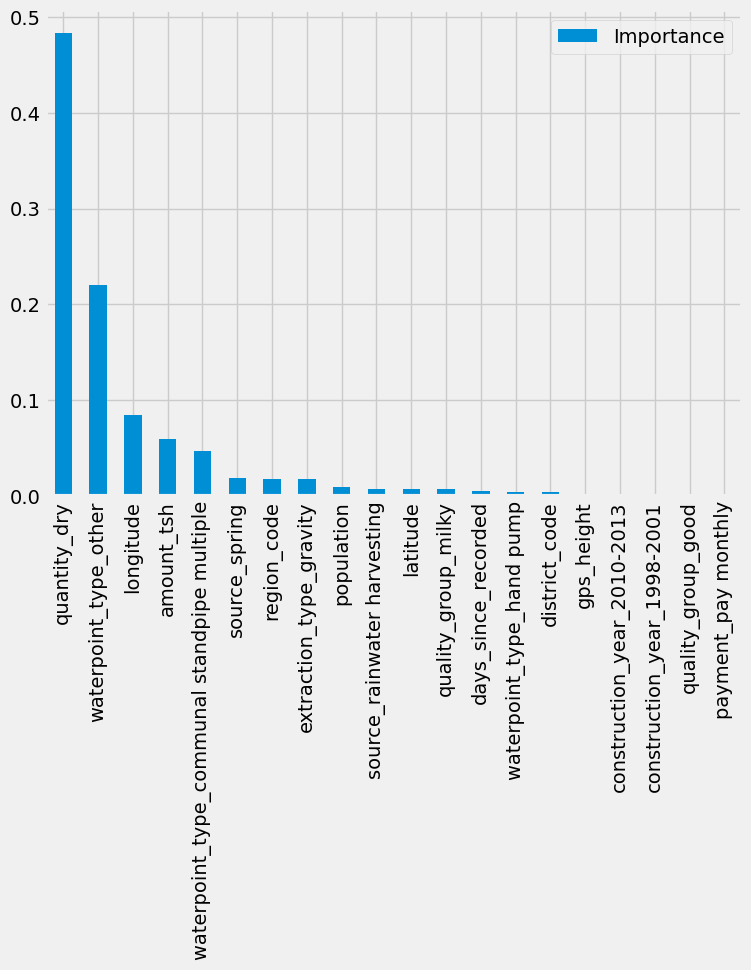

In [180]:
feat_importances.head(20).plot(kind='bar', figsize=(8,6))

In [181]:
feat_importances.head(20)

,Importance
quantity_dry,0.483474
waterpoint_type_other,0.220643
longitude,0.084995
amount_tsh,0.059352
waterpoint_type_communal standpipe multiple,0.047275
source_spring,0.018593
region_code,0.017933
extraction_type_gravity,0.017423
population,0.009022
source_rainwater harvesting,0.007502


# Random Forest Classifier

### Entrenando el modelo

Los datos fueron divididos arriba, no es necesario hacerlo nuevamente.

In [182]:
rfc = RandomForestClassifier()

In [183]:
rfc.fit(X_train, y_train)

RandomForestClassifier()

In [184]:
y_rcf = rfc.predict(X_test)

In [185]:
print('Train set Accuracy: ', metrics.accuracy_score(y_train, rfc.predict(X_train)))
print('Test set Accuracy: ', metrics.accuracy_score(y_test, y_rcf))

Train set Accuracy:  0.9977904040404041
Test set Accuracy:  0.8069023569023569


### Graficar una Confusion Matrix diferente

In [186]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matriz de Confusión',
                          cmap=plt.cm.Blues):
    """
    Esta función nos permite graficar la matriz de confusión.
    La normalización se puede aplicar configurando 'normalize=True'.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusión normalizada")
    else:
        print('Matriz de confusión sin normalizar')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=12)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=10)
    plt.yticks(tick_marks, classes, fontsize=10)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=10)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.grid(False)
    plt.show()


                         precision    recall  f1-score   support

             functional       0.82      0.87      0.84      6421
functional needs repair       0.52      0.38      0.44       872
         non functional       0.83      0.80      0.81      4587

               accuracy                           0.81     11880
              macro avg       0.72      0.68      0.70     11880
           weighted avg       0.80      0.81      0.80     11880

Matriz de confusión sin normalizar
[[5603  215  603]
 [ 409  335  128]
 [ 848   91 3648]]


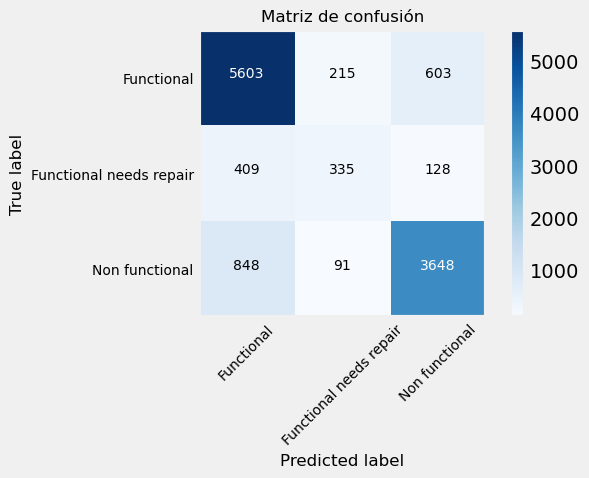

In [187]:
# Calcular matriz de confusión
cnf_matrix = confusion_matrix(y_test,y_rcf)
np.set_printoptions(precision=2)

#Graficar una Confusion Matrix diferente
print (classification_report(y_test,y_rcf))

# Trazar una matriz de confusión no normalizada
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Functional',
                                           'Functional needs repair', 
                                           'Non functional'],
                                            normalize= False,
                                            title='Matriz de confusión')

Esos datos son ya más satisfactorios.

### Importancia de las variables

In [188]:
feat_importances = pd.DataFrame(rfc.feature_importances_, index=X_train_.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)

<Axes: >

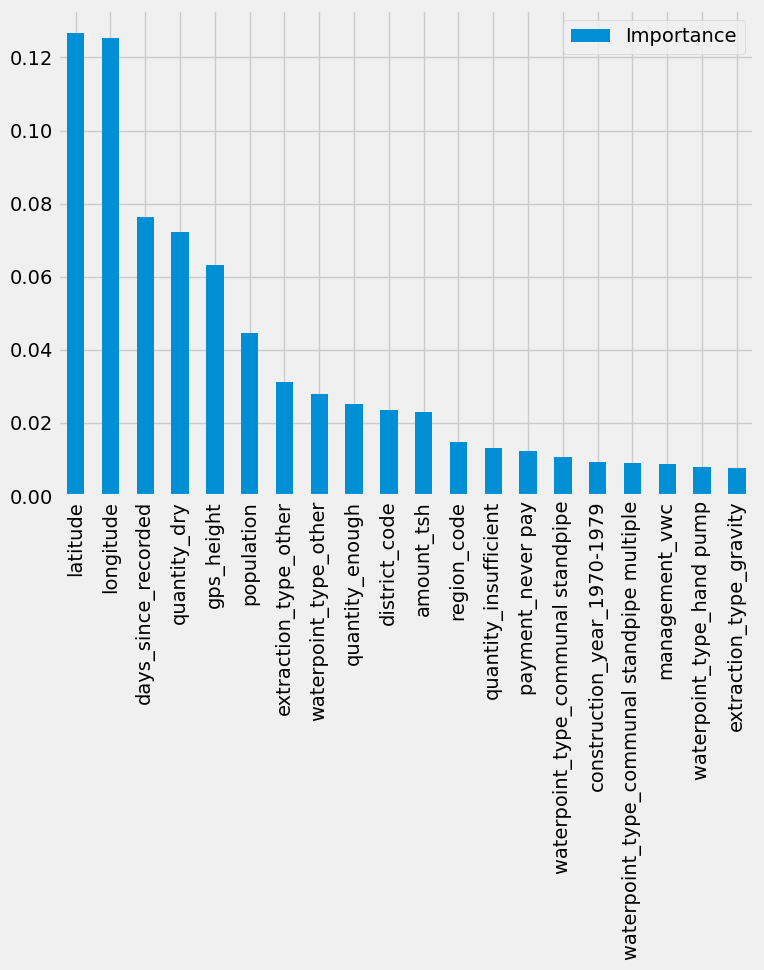

In [189]:
feat_importances.head(20).plot(kind='bar', figsize=(8,6))

In [190]:
feat_importances.head(20)

,Importance
latitude,0.126676
longitude,0.125271
days_since_recorded,0.076253
quantity_dry,0.072318
gps_height,0.063077
population,0.044556
extraction_type_other,0.031107
waterpoint_type_other,0.027788
quantity_enough,0.025208
district_code,0.023464


# Probemos una validación cruzada de Random Forest con Grid Search

Hice una prueva con:

rfc_params = {'n_estimators':[100,120,130,140,150,160],

              'max_depth':[20,22,24,26,28]}

y el mejor fue:

{'max_depth': 24, 'n_estimators': 160}

0.805597643097643

Para fines de correr más rapido el codigo solo pondre dos valores en cada uno

In [191]:
rfc_params = {'n_estimators':[160,170],
              'max_depth':[22,24]}

In [192]:
grid_rfc = GridSearchCV(RandomForestClassifier(), 
                        rfc_params, 
                        cv=5, 
                        scoring='accuracy')

In [193]:
%%time
grid_rfc.fit(X_train, y_train)

CPU times: total: 3min 12s
Wall time: 3min 18s


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [22, 24], 'n_estimators': [160, 170]},
             scoring='accuracy')

Se imprimen los mejores parámetros (model_grid.best_params_) y la mejor puntuación obtenida (model_grid.best_score_).

In [194]:
print(grid_rfc.best_params_)
print(grid_rfc.best_score_)

{'max_depth': 24, 'n_estimators': 160}
0.8057028619528619


In [195]:
y_rfcGS = grid_rfc.predict(X_test)

In [196]:
print('Train set Accuracy: ', metrics.accuracy_score(y_train, grid_rfc.predict(X_train)))
print('Test set Accuracy: ', metrics.accuracy_score(y_test, y_rfcGS))

Train set Accuracy:  0.9628156565656566
Test set Accuracy:  0.8115319865319865


### Confusion Matrix

                         precision    recall  f1-score   support

             functional       0.80      0.90      0.85      6421
functional needs repair       0.59      0.34      0.43       872
         non functional       0.85      0.78      0.81      4587

               accuracy                           0.81     11880
              macro avg       0.75      0.67      0.70     11880
           weighted avg       0.81      0.81      0.80     11880

Matriz de confusión sin normalizar
[[5773  140  508]
 [ 453  293  126]
 [ 946   66 3575]]


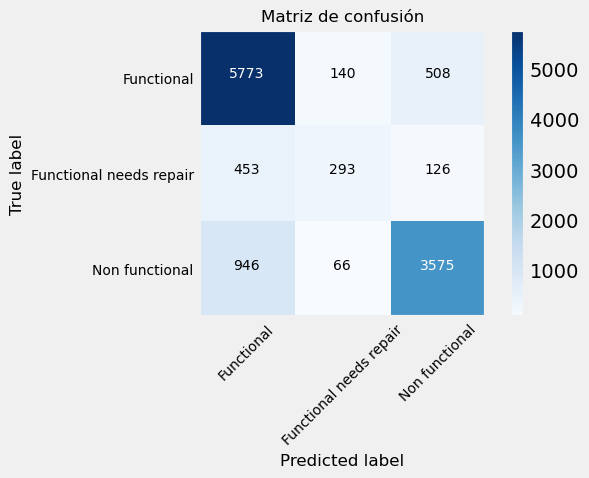

In [197]:
# Calcular matriz de confusión
cnf_matrix = confusion_matrix(y_test, y_rfcGS)
np.set_printoptions(precision=2)

#Graficar una Confusion Matrix diferente
print (classification_report(y_test, y_rfcGS))

# Trazar una matriz de confusión no normalizada
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Functional',
                                           'Functional needs repair', 
                                           'Non functional'],
                                            normalize= False,
                                            title='Matriz de confusión')

# Balanceo de datos

Intento realizar un balanceo de dato, dado que la respuesta *needs repair* está claramente infra representada, por ello el recall de esta respuesta está tan bajo comparado a las dos otras respuestas. El balanceo de datos nos permitirá reequilibrar un poco el numero de occurencia de esta respuesta en la muestra total. Si la prueba no es concluyente, lo dejaremos como era inicialmente.

In [198]:
print("Before OverSampling, counts of label 'functional': {}".format(sum(df['status_group']=='functional')))
print("Before OverSampling, counts of label 'non functional': {} ".format(sum(df['status_group']=='non functional')))
print("Before OverSampling, counts of label 'functional needs repair': {} \n".format(sum(df['status_group']=='functional needs repair')))

Before OverSampling, counts of label 'functional': 32259
Before OverSampling, counts of label 'non functional': 22824 
Before OverSampling, counts of label 'functional needs repair': 4317 



Intente ejecutar el SMOTE con valores por defecto, pero sus valores no fueron buenos:

Lo siguiente son los valores que elijo yo y que dieron un mejor accuracy:

In [199]:
d = {'functional': 32259,'non functional':22824,'functional needs repair':9000}

In [200]:
X_sm, y_sm = SMOTE(sampling_strategy=d, random_state=42).fit_resample(X,y)

In [201]:
print('After OverSampling, the shape of train_X: {}'.format(X_sm.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_sm.shape))

After OverSampling, the shape of train_X: (64083, 127)
After OverSampling, the shape of train_y: (64083,) 



In [202]:
print("After OverSampling, counts of label 'functional': {}".format(sum(y_sm=='functional')))
print("After OverSampling, counts of label 'non functional': {}".format(sum(y_sm=='non functional')))
print("After OverSampling, counts of label 'functional needs repair': {}".format(sum(y_sm== 'functional needs repair')))

After OverSampling, counts of label 'functional': 32259
After OverSampling, counts of label 'non functional': 22824
After OverSampling, counts of label 'functional needs repair': 9000


In [203]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_sm,
                                                    y_sm,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify = y_sm)

In [204]:
balanceo = RandomForestClassifier(n_estimators=160, max_depth=24).fit(X_train_sm,y_train_sm)
y_pred_sm = balanceo.predict(X_test_sm)

In [205]:
print('Train set Accuracy: ', metrics.accuracy_score(y_train_sm, balanceo.predict(X_train_sm)))
print('Test set Accuracy: ', metrics.accuracy_score(y_test_sm, y_pred_sm))

Train set Accuracy:  0.9592907580072563
Test set Accuracy:  0.8196145743933838


                         precision    recall  f1-score   support

             functional       0.80      0.90      0.85      6452
functional needs repair       0.83      0.66      0.73      1800
         non functional       0.86      0.76      0.81      4565

               accuracy                           0.82     12817
              macro avg       0.83      0.78      0.80     12817
           weighted avg       0.82      0.82      0.82     12817

Matriz de confusión sin normalizar
[[5829  177  446]
 [ 483 1191  126]
 [1006   74 3485]]


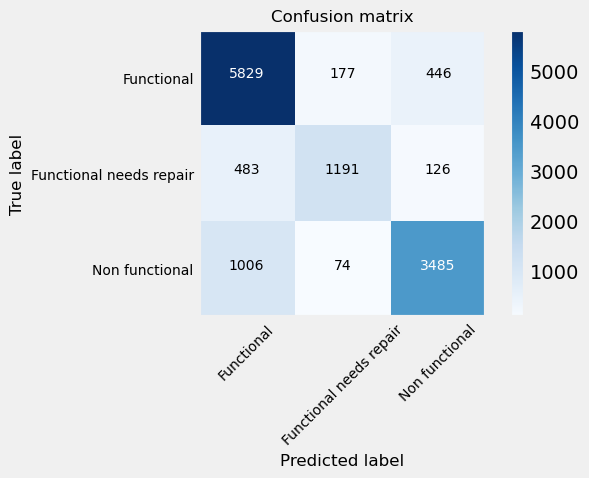

In [206]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_sm, y_pred_sm)
np.set_printoptions(precision=2)

print (classification_report(y_test_sm, y_pred_sm))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Functional',
                                           'Functional needs repair', 
                                           'Non functional'],
                                            normalize= False,
                                            title='Confusion matrix')

# Datos de prueba a través de Random Forest - ¡Hagamos las predicciones!

In [207]:
X1 = df_test.drop(columns = ['id']).values

In [208]:
y_p1 = rfc.predict(X1)

In [209]:
preds = pd.DataFrame(y_p1)

In [210]:
preds.head()

,0
0,functional
1,functional
2,functional
3,non functional
4,functional


In [211]:
df_test.shape, preds.shape

((14850, 128), (14850, 1))

In [212]:
predict = pd.concat((df_test['id'], preds), axis=1)

In [213]:
predict.columns=['id', 'status_group']

In [214]:
predict['status_group'].unique()

array(['functional', 'non functional', 'functional needs repair'],
      dtype=object)

In [215]:
predict.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [216]:
predict.tail()

,id,status_group
14845,39307,non functional
14846,18990,functional
14847,28749,functional
14848,33492,functional
14849,68707,non functional


In [217]:
predict.to_csv('Submission_08065.csv', index=False)

# Datos de prueba a través de Random Forest con Grid Search - ¡Hagamos las predicciones!

### Este es el modelo seleccionado pues su envío (submission) nos da el mejor resultado (0.8172)

Estos son los resultados para el modelo 'grid_rfc':

Train set Accuracy:  0.9628156565656566

Test set Accuracy:  0.8115319865319865

In [218]:
X2 = df_test.drop(columns = ['id']).values

In [219]:
y_p2 = grid_rfc.predict(X2)

In [220]:
preds = pd.DataFrame(y_p2)

In [221]:
preds.head()

,0
0,functional
1,functional
2,functional
3,non functional
4,functional


In [222]:
df_test.shape, preds.shape

((14850, 128), (14850, 1))

In [223]:
predict = pd.concat((df_test['id'], preds), axis=1)

In [224]:
predict.columns=['id', 'status_group']

In [225]:
predict['status_group'].unique()

array(['functional', 'non functional', 'functional needs repair'],
      dtype=object)

In [226]:
predict.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [227]:
predict.tail()

,id,status_group
14845,39307,non functional
14846,18990,functional
14847,28749,functional
14848,33492,functional
14849,68707,non functional


In [228]:
predict.to_csv('Submission_08153.csv', index=False)

# Datos de prueba a través Balanceo - Hagamos las predicciones

Aunque este nos da un mejor "Accuracy" y datos en general, por alguna razon no termina siendo el mejor prediciendo los resultados, pues obtenemos un 0.8129, lo cual es menor al anterior (0.8172).

Resultados para el modelo 'balanceo':

Train set Accuracy:  0.9592907580072563

Test set Accuracy:  0.8196145743933838

**VS**

Resultados para el modelo 'grid_rfc':

Train set Accuracy:  0.9628156565656566

Test set Accuracy:  0.8115319865319865

In [229]:
X = df_test.drop(columns = ['id']).values

In [230]:
y_p = balanceo.predict(X)

In [231]:
preds = pd.DataFrame(y_p)

In [232]:
preds.head()

,0
0,non functional
1,functional
2,functional
3,non functional
4,functional


In [233]:
df_test.shape, preds.shape

((14850, 128), (14850, 1))

In [234]:
predict = pd.concat((df_test['id'], preds), axis=1)

In [235]:
predict.columns=['id', 'status_group']

In [236]:
predict['status_group'].unique()

array(['non functional', 'functional', 'functional needs repair'],
      dtype=object)

In [237]:
predict.head()

,id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [238]:
predict.tail()

,id,status_group
14845,39307,non functional
14846,18990,functional
14847,28749,functional
14848,33492,functional
14849,68707,non functional


In [239]:
predict.to_csv('Submission_08125.csv', index=False)